### Import

In [90]:
import os
import random
import pandas as pd
import numpy as np
import json
import optuna

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Lipinski

import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [91]:
CFG = {
    'NBITS': 2048,
    'SEED': 42,
    'N_SPLITS': 5,
    'N_TRIALS': 200
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

In [92]:
def IC50_to_pIC50(ic50_nM):
    ic50_nM = np.clip(ic50_nM, 1e-10, None)
    return 9 - np.log10(ic50_nM)

In [93]:
def pIC50_to_IC50(pIC50):
    return 10 ** (9 - pIC50)

In [94]:
def get_score(y_true_ic50, y_pred_ic50, y_true_pic50, y_pred_pic50):
    rmse = mean_squared_error(y_true_ic50, y_pred_ic50) ** 0.5
    nrmse = rmse / (np.max(y_true_ic50) - np.min(y_true_ic50))
    A = 1 - min(nrmse, 1)
    B = r2_score(y_true_pic50, y_pred_pic50)
    score = 0.4 * A + 0.6 * B
    return score

### Data loading & Molcular descriptor

In [95]:
IC50_dataset = pd.read_csv("C:/Users/user/Desktop/dacon_drug_development/IC50_dataset.csv")
IC50_dataset['Fingerprint'] = IC50_dataset['smiles'].apply(smiles_to_fingerprint)

[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerator
[11:08:57] DEPRECATION WARNING: please use MorganGenerat

In [96]:
def descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    f = {}
    # 1. 화학기 존재 여부
    # Tetrazole ring
    tetrazole_smarts = ['c1nn[n+](n1)[O-]', 'c1[nH]nnn1']
    f['has_tetrazole'] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in tetrazole_smarts)
    # Triazole ring
    f['has_triazole'] = mol.HasSubstructMatch(Chem.MolFromSmarts('c1nnc(n1)'))
    # Sulfoxide group
    f['has_sulfoxide'] = mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(C)'))
    # Amide carbonyl
    amide_smarts = ['C(=O)N', 'NC(=O)']
    f['has_amide'] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in amide_smarts)
    # Sulfonamide group
    f['has_sulfonamide'] = mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(=O)N'))
    
    # 2. 분자량
    mw = Descriptors.MolWt(mol)
    f['mw'] = mw
    f['mw_300_500'] = 300<=mw<=500
    
    # 3. logP
    logp = Descriptors.MolLogP(mol)
    f['logP'] = logp
    f['logP_2_4'] = 2<=logp<=4
    
    # 4. TPSA
    tpsa = Descriptors.TPSA(mol)
    f['TPSA'] = tpsa
    f['TPSA_60_120'] = 60<=tpsa<=120
    
    # 5. rotatable bonds (IC50 값 높임_bad)
    rot = Lipinski.NumRotatableBonds(mol)
    f['rotatable'] = rot
    f['rot_gt7'] = rot>7

    # 6. ring (+aromatic)
    # ring 2개 이상
    num_rings = mol.GetRingInfo().NumRings()
    f['num_rings'] = num_rings
    f['ring_count_ge_2'] = num_rings >= 2
    # aromatic ring 존재 여부
    ssr = Chem.GetSymmSSSR(mol)
    aromatic_ring = any(all(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring) for ring in ssr)
    f['has_aromatic_ring'] = aromatic_ring
    # Ring 2개 이상 + 그 중 적어도 하나 aromatic인가?
    f['ring_ge2_and_aromatic'] = f['ring_count_ge_2'] and f['has_aromatic_ring']

    return f

In [97]:
features_df = pd.DataFrame([descriptors(s) for s in IC50_dataset['smiles']])
final_dataset = pd.concat([IC50_dataset, features_df], axis=1)

### Train/Validation data split

In [98]:
# XGBoost에 넣으려면, Fingerprint를 실제 숫자 벡터 컬럼으로 풀어줘야 함.
# 예를 들어, [0, 1, 0, 1] → fp_0=0, fp_1=1, fp_2=0, fp_3=1 이렇게 컬럼별 숫자로 변환.

# 1. Fingerprint 컬럼을 여러 개 숫자 컬럼으로 변환
fp_df = pd.DataFrame(final_dataset['Fingerprint'].tolist(), index=final_dataset.index)

# 2. 컬럼 이름 부여 (fp_0, fp_1, ...)
fp_df.columns = [f'fp_{i}' for i in range(fp_df.shape[1])]

# 3. 기존 데이터에서 Fingerprint 컬럼 제거 후 합치기
final_dataset = pd.concat(
    [final_dataset.drop(columns=['Fingerprint']), fp_df],
    axis=1
)

In [99]:
# Define X (features) and y (target)
X = final_dataset.drop(['smiles', 'IC50_nM', 'pIC50'], axis=1)
y = final_dataset['pIC50']

In [100]:
# Split the data into training and testing sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Building LGBM model

In [101]:
# k-fold cross-validation
def lgb_kfold_cv(params, X_trainval, y_trainval, n_splits=CFG['N_SPLITS'], seed=CFG['SEED']):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof_preds = np.zeros(len(X_trainval))
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval, y_trainval)):
        X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )

        val_preds = model.predict(X_val)
        oof_preds[val_idx] = val_preds

        # 점수 계산 (pIC50->IC50 변환 포함)
        y_val_ic50 = pIC50_to_IC50(y_val)
        val_preds_ic50 = pIC50_to_IC50(val_preds)
        score = get_score(y_val_ic50, val_preds_ic50, y_val, val_preds)
        print(f"Fold {fold+1} score: {score:.6f}")
        fold_scores.append(score)

    avg_score = np.mean(fold_scores)
    print(f"Average CV score: {avg_score:.6f}")
    return avg_score, oof_preds, fold_scores

In [102]:
def objective(trial, X, y):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.2),
        'seed': 42
    }

    avg_score, _, _ = lgb_kfold_cv(params, X, y, n_splits=CFG['N_SPLITS'], seed=CFG['SEED'])
    
    return avg_score

In [103]:
sampler = optuna.samplers.CmaEsSampler()

study = optuna.create_study(direction='minimize', study_name='lgbm_tuning', sampler=sampler)
study.optimize(lambda trial: objective(trial, X_trainval, y_trainval), n_trials=CFG['N_TRIALS'])

[I 2025-08-11 11:09:48,544] A new study created in memory with name: lgbm_tuning


Fold 1 score: 0.577366
Fold 2 score: 0.555953
Fold 3 score: 0.558087
Fold 4 score: 0.514466


[I 2025-08-11 11:09:50,906] Trial 0 finished with value: 0.5375229750983924 and parameters: {'learning_rate': 0.012009684380654534, 'num_leaves': 56, 'max_depth': 3, 'feature_fraction': 0.9703901381180059, 'bagging_fraction': 0.8235908028865702, 'bagging_freq': 5, 'min_child_samples': 21, 'lambda_l1': 0.3839139165628034, 'lambda_l2': 0.5905596182040379, 'min_split_gain': 0.18686864473709308}. Best is trial 0 with value: 0.5375229750983924.


Fold 5 score: 0.481743
Average CV score: 0.537523
Fold 1 score: 0.576458
Fold 2 score: 0.557974
Fold 3 score: 0.553207
Fold 4 score: 0.513519


[I 2025-08-11 11:09:52,523] Trial 1 finished with value: 0.5369047771404412 and parameters: {'learning_rate': 0.028814347330062218, 'num_leaves': 52, 'max_depth': 3, 'feature_fraction': 0.8554882782017355, 'bagging_fraction': 0.856161511311629, 'bagging_freq': 4, 'min_child_samples': 26, 'lambda_l1': 0.5224653127580093, 'lambda_l2': 0.6422343313323631, 'min_split_gain': 0.17295075359999815}. Best is trial 1 with value: 0.5369047771404412.


Fold 5 score: 0.483366
Average CV score: 0.536905
Fold 1 score: 0.575489
Fold 2 score: 0.547493
Fold 3 score: 0.544981
Fold 4 score: 0.512770


[I 2025-08-11 11:09:55,121] Trial 2 finished with value: 0.5343297567726897 and parameters: {'learning_rate': 0.010825333316106977, 'num_leaves': 48, 'max_depth': 7, 'feature_fraction': 0.8548703442952656, 'bagging_fraction': 0.8290333143037942, 'bagging_freq': 4, 'min_child_samples': 29, 'lambda_l1': 0.6694900612550019, 'lambda_l2': 0.5772939992913352, 'min_split_gain': 0.12638250579854704}. Best is trial 2 with value: 0.5343297567726897.


Fold 5 score: 0.490915
Average CV score: 0.534330
Fold 1 score: 0.579015
Fold 2 score: 0.542442
Fold 3 score: 0.544083
Fold 4 score: 0.515916


[I 2025-08-11 11:09:58,088] Trial 3 finished with value: 0.5356794997843002 and parameters: {'learning_rate': 0.00681437544224125, 'num_leaves': 36, 'max_depth': 6, 'feature_fraction': 0.9282123077546507, 'bagging_fraction': 0.878576472793184, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.3904787125954921, 'lambda_l2': 0.3495812719747524, 'min_split_gain': 0.0657549699592017}. Best is trial 2 with value: 0.5343297567726897.


Fold 5 score: 0.496942
Average CV score: 0.535679
Fold 1 score: 0.577019
Fold 2 score: 0.553036
Fold 3 score: 0.548308
Fold 4 score: 0.515383


[I 2025-08-11 11:10:02,217] Trial 4 finished with value: 0.5357627300770986 and parameters: {'learning_rate': 0.0031287579667464904, 'num_leaves': 51, 'max_depth': 6, 'feature_fraction': 0.8648803894879519, 'bagging_fraction': 0.8642967667809862, 'bagging_freq': 5, 'min_child_samples': 28, 'lambda_l1': 0.49072998775523324, 'lambda_l2': 0.3395107419074769, 'min_split_gain': 0.11809072377117771}. Best is trial 2 with value: 0.5343297567726897.


Fold 5 score: 0.485068
Average CV score: 0.535763
Fold 1 score: 0.578407
Fold 2 score: 0.548820
Fold 3 score: 0.544041
Fold 4 score: 0.516050


[I 2025-08-11 11:10:06,386] Trial 5 finished with value: 0.5355341444616237 and parameters: {'learning_rate': 0.004330763799701022, 'num_leaves': 64, 'max_depth': 7, 'feature_fraction': 0.7574597481728537, 'bagging_fraction': 0.8451016501891382, 'bagging_freq': 3, 'min_child_samples': 36, 'lambda_l1': 0.47912965360784626, 'lambda_l2': 0.47278563204495144, 'min_split_gain': 0.06910572323555288}. Best is trial 2 with value: 0.5343297567726897.


Fold 5 score: 0.490353
Average CV score: 0.535534
Fold 1 score: 0.577654
Fold 2 score: 0.548968
Fold 3 score: 0.550392
Fold 4 score: 0.516415


[I 2025-08-11 11:10:14,645] Trial 6 finished with value: 0.5372738595692103 and parameters: {'learning_rate': 0.0019677955800637753, 'num_leaves': 68, 'max_depth': 6, 'feature_fraction': 0.7427359829765311, 'bagging_fraction': 0.9309474663194748, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 0.2619604509863432, 'lambda_l2': 0.38132706537061467, 'min_split_gain': 0.05350226986356767}. Best is trial 2 with value: 0.5343297567726897.


Fold 5 score: 0.492941
Average CV score: 0.537274
Fold 1 score: 0.580020
Fold 2 score: 0.554939
Fold 3 score: 0.552234
Fold 4 score: 0.512951


[I 2025-08-11 11:10:17,743] Trial 7 finished with value: 0.5369902717989214 and parameters: {'learning_rate': 0.011933343579688829, 'num_leaves': 50, 'max_depth': 5, 'feature_fraction': 0.8377367849921276, 'bagging_fraction': 0.8260771494934491, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 0.5534928502210815, 'lambda_l2': 0.5523668681528876, 'min_split_gain': 0.17779587530031732}. Best is trial 2 with value: 0.5343297567726897.


Fold 5 score: 0.484807
Average CV score: 0.536990
Fold 1 score: 0.580491
Fold 2 score: 0.548650
Fold 3 score: 0.545193
Fold 4 score: 0.513858


[I 2025-08-11 11:10:22,595] Trial 8 finished with value: 0.5353367387032734 and parameters: {'learning_rate': 0.004650478338672861, 'num_leaves': 53, 'max_depth': 6, 'feature_fraction': 0.8809703192090383, 'bagging_fraction': 0.7260816824712318, 'bagging_freq': 2, 'min_child_samples': 28, 'lambda_l1': 0.4836320348847127, 'lambda_l2': 0.4361494847543582, 'min_split_gain': 0.06751133890208137}. Best is trial 2 with value: 0.5343297567726897.


Fold 5 score: 0.488491
Average CV score: 0.535337
Fold 1 score: 0.579897
Fold 2 score: 0.556022
Fold 3 score: 0.551114
Fold 4 score: 0.513632


[I 2025-08-11 11:10:27,513] Trial 9 finished with value: 0.5353874598924737 and parameters: {'learning_rate': 0.0070589485002588645, 'num_leaves': 44, 'max_depth': 3, 'feature_fraction': 0.7905527208053502, 'bagging_fraction': 0.8147477683745954, 'bagging_freq': 3, 'min_child_samples': 32, 'lambda_l1': 0.44470932535623425, 'lambda_l2': 0.5727161694298337, 'min_split_gain': 0.08082114559279345}. Best is trial 2 with value: 0.5343297567726897.


Fold 5 score: 0.476272
Average CV score: 0.535387
Fold 1 score: 0.577990
Fold 2 score: 0.548980
Fold 3 score: 0.541214
Fold 4 score: 0.513325


[I 2025-08-11 11:10:33,692] Trial 10 finished with value: 0.533986523488408 and parameters: {'learning_rate': 0.003936003624866512, 'num_leaves': 52, 'max_depth': 7, 'feature_fraction': 0.851554411944341, 'bagging_fraction': 0.8096167663306104, 'bagging_freq': 3, 'min_child_samples': 22, 'lambda_l1': 0.30777789484847046, 'lambda_l2': 0.590872691687722, 'min_split_gain': 0.10408716801348883}. Best is trial 10 with value: 0.533986523488408.


Fold 5 score: 0.488423
Average CV score: 0.533987
Fold 1 score: 0.576552
Fold 2 score: 0.548678
Fold 3 score: 0.546439
Fold 4 score: 0.513696


[I 2025-08-11 11:10:46,035] Trial 11 finished with value: 0.5341042552700672 and parameters: {'learning_rate': 0.0013717405452829655, 'num_leaves': 43, 'max_depth': 6, 'feature_fraction': 0.8438980024630975, 'bagging_fraction': 0.7284181747721108, 'bagging_freq': 2, 'min_child_samples': 22, 'lambda_l1': 0.47444548735576264, 'lambda_l2': 0.4946117062888641, 'min_split_gain': 0.1424255175858838}. Best is trial 10 with value: 0.533986523488408.


Fold 5 score: 0.485157
Average CV score: 0.534104
Fold 1 score: 0.581719
Fold 2 score: 0.550391
Fold 3 score: 0.546115
Fold 4 score: 0.515776


[I 2025-08-11 11:10:49,403] Trial 12 finished with value: 0.5363291613458891 and parameters: {'learning_rate': 0.011476149736444313, 'num_leaves': 56, 'max_depth': 6, 'feature_fraction': 0.8228203392042573, 'bagging_fraction': 0.797344013925486, 'bagging_freq': 2, 'min_child_samples': 19, 'lambda_l1': 0.23619749311115454, 'lambda_l2': 0.8054559387132796, 'min_split_gain': 0.09981468295784533}. Best is trial 10 with value: 0.533986523488408.


Fold 5 score: 0.487645
Average CV score: 0.536329
Fold 1 score: 0.580309
Fold 2 score: 0.551133
Fold 3 score: 0.547110
Fold 4 score: 0.513232


[I 2025-08-11 11:10:51,739] Trial 13 finished with value: 0.5360675124265741 and parameters: {'learning_rate': 0.010616139866151298, 'num_leaves': 38, 'max_depth': 6, 'feature_fraction': 0.8169118160743457, 'bagging_fraction': 0.8045752400222547, 'bagging_freq': 3, 'min_child_samples': 27, 'lambda_l1': 0.45870644461102644, 'lambda_l2': 0.5504193157465282, 'min_split_gain': 0.09406377060393965}. Best is trial 10 with value: 0.533986523488408.


Fold 5 score: 0.488553
Average CV score: 0.536068
Fold 1 score: 0.576416
Fold 2 score: 0.544324
Fold 3 score: 0.539524
Fold 4 score: 0.513287


[I 2025-08-11 11:10:57,127] Trial 14 finished with value: 0.5326362546826645 and parameters: {'learning_rate': 0.0032422255219247123, 'num_leaves': 46, 'max_depth': 8, 'feature_fraction': 0.8503223541367165, 'bagging_fraction': 0.8009846597863237, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 0.3276016779347187, 'lambda_l2': 0.7464220236847837, 'min_split_gain': 0.09636095086732886}. Best is trial 14 with value: 0.5326362546826645.


Fold 5 score: 0.489630
Average CV score: 0.532636
Fold 1 score: 0.578021
Fold 2 score: 0.550803
Fold 3 score: 0.545368
Fold 4 score: 0.513623


[I 2025-08-11 11:11:02,284] Trial 15 finished with value: 0.5353690275209245 and parameters: {'learning_rate': 0.003506465864002911, 'num_leaves': 42, 'max_depth': 6, 'feature_fraction': 0.9064611413329268, 'bagging_fraction': 0.80205764060247, 'bagging_freq': 3, 'min_child_samples': 24, 'lambda_l1': 0.28302481770847365, 'lambda_l2': 0.557883670644185, 'min_split_gain': 0.04996714440476825}. Best is trial 14 with value: 0.5326362546826645.


Fold 5 score: 0.489029
Average CV score: 0.535369
Fold 1 score: 0.575790
Fold 2 score: 0.543410
Fold 3 score: 0.536619
Fold 4 score: 0.512874


[I 2025-08-11 11:11:06,309] Trial 16 finished with value: 0.5323433541561113 and parameters: {'learning_rate': 0.004432153238919659, 'num_leaves': 57, 'max_depth': 8, 'feature_fraction': 0.8296129678967294, 'bagging_fraction': 0.8063667894975987, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 0.2328037164453272, 'lambda_l2': 0.8883503411960139, 'min_split_gain': 0.09946881605131223}. Best is trial 16 with value: 0.5323433541561113.


Fold 5 score: 0.493025
Average CV score: 0.532343
Fold 1 score: 0.578149
Fold 2 score: 0.549228
Fold 3 score: 0.542618
Fold 4 score: 0.514940


[I 2025-08-11 11:11:10,302] Trial 17 finished with value: 0.5349129453650376 and parameters: {'learning_rate': 0.005967087242032054, 'num_leaves': 36, 'max_depth': 7, 'feature_fraction': 0.8305888532745799, 'bagging_fraction': 0.7720626694672702, 'bagging_freq': 3, 'min_child_samples': 31, 'lambda_l1': 0.3109470502975348, 'lambda_l2': 0.36227315369365953, 'min_split_gain': 0.06284174907480002}. Best is trial 16 with value: 0.5323433541561113.


Fold 5 score: 0.489629
Average CV score: 0.534913
Fold 1 score: 0.579879
Fold 2 score: 0.549563
Fold 3 score: 0.544386
Fold 4 score: 0.515623


[I 2025-08-11 11:11:17,320] Trial 18 finished with value: 0.5351456257230709 and parameters: {'learning_rate': 0.0037036428927270733, 'num_leaves': 48, 'max_depth': 6, 'feature_fraction': 0.8765814582145538, 'bagging_fraction': 0.7571512517571858, 'bagging_freq': 3, 'min_child_samples': 31, 'lambda_l1': 0.38768846158922854, 'lambda_l2': 0.5482629328755955, 'min_split_gain': 0.06019352814768031}. Best is trial 16 with value: 0.5323433541561113.


Fold 5 score: 0.486276
Average CV score: 0.535146
Fold 1 score: 0.577081
Fold 2 score: 0.543093
Fold 3 score: 0.536872
Fold 4 score: 0.513613


[I 2025-08-11 11:11:20,654] Trial 19 finished with value: 0.5320934080804338 and parameters: {'learning_rate': 0.017065275283262654, 'num_leaves': 52, 'max_depth': 8, 'feature_fraction': 0.786245306593403, 'bagging_fraction': 0.8246278559317372, 'bagging_freq': 3, 'min_child_samples': 22, 'lambda_l1': 0.24062050400982576, 'lambda_l2': 0.7345547796020901, 'min_split_gain': 0.047214388248778695}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.489808
Average CV score: 0.532093
Fold 1 score: 0.577094
Fold 2 score: 0.549422
Fold 3 score: 0.548603
Fold 4 score: 0.516080


[I 2025-08-11 11:11:29,651] Trial 20 finished with value: 0.5366690887112251 and parameters: {'learning_rate': 0.001963268122433165, 'num_leaves': 55, 'max_depth': 6, 'feature_fraction': 0.8431561887995902, 'bagging_fraction': 0.8527752541152724, 'bagging_freq': 3, 'min_child_samples': 18, 'lambda_l1': 0.5869809833582784, 'lambda_l2': 0.572488488118863, 'min_split_gain': 0.12123368455231126}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.492147
Average CV score: 0.536669
Fold 1 score: 0.576938
Fold 2 score: 0.545419
Fold 3 score: 0.544216
Fold 4 score: 0.515483


[I 2025-08-11 11:11:43,049] Trial 21 finished with value: 0.5355497488226836 and parameters: {'learning_rate': 0.0013646783269876945, 'num_leaves': 47, 'max_depth': 7, 'feature_fraction': 0.7556815222592883, 'bagging_fraction': 0.7921116372996858, 'bagging_freq': 2, 'min_child_samples': 16, 'lambda_l1': 0.29388220703229395, 'lambda_l2': 0.295010124437472, 'min_split_gain': 0.08231098065751122}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.495693
Average CV score: 0.535550
Fold 1 score: 0.574420
Fold 2 score: 0.546411
Fold 3 score: 0.540591
Fold 4 score: 0.511349


[I 2025-08-11 11:11:46,723] Trial 22 finished with value: 0.533089726256041 and parameters: {'learning_rate': 0.00926258802159325, 'num_leaves': 47, 'max_depth': 8, 'feature_fraction': 0.8832191683835358, 'bagging_fraction': 0.8479558592452517, 'bagging_freq': 2, 'min_child_samples': 23, 'lambda_l1': 0.4887555173357211, 'lambda_l2': 0.888479014264867, 'min_split_gain': 0.059630448702128816}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.492679
Average CV score: 0.533090
Fold 1 score: 0.577500
Fold 2 score: 0.557442
Fold 3 score: 0.552750
Fold 4 score: 0.513573


[I 2025-08-11 11:11:50,541] Trial 23 finished with value: 0.5378864535914489 and parameters: {'learning_rate': 0.00994055493397089, 'num_leaves': 51, 'max_depth': 5, 'feature_fraction': 0.8700739502960542, 'bagging_fraction': 0.8430235486834683, 'bagging_freq': 3, 'min_child_samples': 23, 'lambda_l1': 0.19589327359714764, 'lambda_l2': 0.7709822248199518, 'min_split_gain': 0.09001333368373203}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.488167
Average CV score: 0.537886
Fold 1 score: 0.577137
Fold 2 score: 0.546504
Fold 3 score: 0.541167
Fold 4 score: 0.513799


[I 2025-08-11 11:11:54,026] Trial 24 finished with value: 0.5340472943095033 and parameters: {'learning_rate': 0.011528055975840463, 'num_leaves': 60, 'max_depth': 7, 'feature_fraction': 0.7786568078584644, 'bagging_fraction': 0.8139062924735313, 'bagging_freq': 2, 'min_child_samples': 19, 'lambda_l1': 0.43693101517646316, 'lambda_l2': 0.6076290082664517, 'min_split_gain': 0.08858903789617659}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.491630
Average CV score: 0.534047
Fold 1 score: 0.576107
Fold 2 score: 0.545426
Fold 3 score: 0.538785
Fold 4 score: 0.511791


[I 2025-08-11 11:12:02,741] Trial 25 finished with value: 0.5322268394688553 and parameters: {'learning_rate': 0.0024826967986965685, 'num_leaves': 44, 'max_depth': 8, 'feature_fraction': 0.8284969745619952, 'bagging_fraction': 0.8173455406792433, 'bagging_freq': 3, 'min_child_samples': 26, 'lambda_l1': 0.5425222883128693, 'lambda_l2': 0.9920132682307184, 'min_split_gain': 0.06081181669471378}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.489025
Average CV score: 0.532227
Fold 1 score: 0.576418
Fold 2 score: 0.545408
Fold 3 score: 0.538470
Fold 4 score: 0.511748


[I 2025-08-11 11:12:09,377] Trial 26 finished with value: 0.5326647012183481 and parameters: {'learning_rate': 0.003213819281332704, 'num_leaves': 55, 'max_depth': 8, 'feature_fraction': 0.8217224314480196, 'bagging_fraction': 0.8474003929206283, 'bagging_freq': 3, 'min_child_samples': 24, 'lambda_l1': 0.2132059919845828, 'lambda_l2': 0.8144145534625522, 'min_split_gain': 0.10635290019436468}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.491279
Average CV score: 0.532665
Fold 1 score: 0.575789
Fold 2 score: 0.545052
Fold 3 score: 0.541864
Fold 4 score: 0.511415


[I 2025-08-11 11:12:13,975] Trial 27 finished with value: 0.5330577849503325 and parameters: {'learning_rate': 0.005401597659755695, 'num_leaves': 44, 'max_depth': 8, 'feature_fraction': 0.7739065106739134, 'bagging_fraction': 0.9269658652993633, 'bagging_freq': 4, 'min_child_samples': 25, 'lambda_l1': 0.17677545537984116, 'lambda_l2': 0.8591466671336812, 'min_split_gain': 0.10319604294111678}. Best is trial 19 with value: 0.5320934080804338.


Fold 5 score: 0.491169
Average CV score: 0.533058
Fold 1 score: 0.576226
Fold 2 score: 0.538807
Fold 3 score: 0.538463
Fold 4 score: 0.515728


[I 2025-08-11 11:12:16,237] Trial 28 finished with value: 0.5318282984692752 and parameters: {'learning_rate': 0.02857228384248877, 'num_leaves': 42, 'max_depth': 8, 'feature_fraction': 0.7790587888187667, 'bagging_fraction': 0.7809702595659538, 'bagging_freq': 3, 'min_child_samples': 25, 'lambda_l1': 0.22123748851051322, 'lambda_l2': 0.781001858050589, 'min_split_gain': 0.13186506456909194}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.489917
Average CV score: 0.531828
Fold 1 score: 0.578968
Fold 2 score: 0.544202
Fold 3 score: 0.538855
Fold 4 score: 0.514123


[I 2025-08-11 11:12:21,972] Trial 29 finished with value: 0.5341530434721162 and parameters: {'learning_rate': 0.004253112526433418, 'num_leaves': 50, 'max_depth': 8, 'feature_fraction': 0.720808349906525, 'bagging_fraction': 0.7984949619151791, 'bagging_freq': 3, 'min_child_samples': 18, 'lambda_l1': 0.21497686553006706, 'lambda_l2': 0.6829539052433156, 'min_split_gain': 0.035339434988691174}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.494616
Average CV score: 0.534153
Fold 1 score: 0.576147
Fold 2 score: 0.551508
Fold 3 score: 0.548905
Fold 4 score: 0.518325


[I 2025-08-11 11:12:24,914] Trial 30 finished with value: 0.5370462729126763 and parameters: {'learning_rate': 0.014840313766238756, 'num_leaves': 64, 'max_depth': 6, 'feature_fraction': 0.901122390235226, 'bagging_fraction': 0.8820592359721309, 'bagging_freq': 4, 'min_child_samples': 21, 'lambda_l1': 0.22882693883326558, 'lambda_l2': 0.6483505114070116, 'min_split_gain': 0.07278281770962648}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.490346
Average CV score: 0.537046
Fold 1 score: 0.578046
Fold 2 score: 0.548891
Fold 3 score: 0.545726
Fold 4 score: 0.517724


[I 2025-08-11 11:12:27,924] Trial 31 finished with value: 0.5366281959358081 and parameters: {'learning_rate': 0.01401812631416601, 'num_leaves': 47, 'max_depth': 7, 'feature_fraction': 0.7226342054318152, 'bagging_fraction': 0.8840482618595054, 'bagging_freq': 3, 'min_child_samples': 23, 'lambda_l1': 0.5682352741387376, 'lambda_l2': 0.8328592849674255, 'min_split_gain': 0.10417832644206695}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.492755
Average CV score: 0.536628
Fold 1 score: 0.577375
Fold 2 score: 0.545590
Fold 3 score: 0.539976
Fold 4 score: 0.512145


[I 2025-08-11 11:12:31,949] Trial 32 finished with value: 0.5334494290688399 and parameters: {'learning_rate': 0.009309245247558454, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.7372525369579856, 'bagging_fraction': 0.7828015313367049, 'bagging_freq': 2, 'min_child_samples': 20, 'lambda_l1': 0.416691877017833, 'lambda_l2': 0.7817347212520602, 'min_split_gain': 0.07535462363593437}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.492162
Average CV score: 0.533449
Fold 1 score: 0.578859
Fold 2 score: 0.553605
Fold 3 score: 0.550790
Fold 4 score: 0.514585


[I 2025-08-11 11:12:37,655] Trial 33 finished with value: 0.5359964348641209 and parameters: {'learning_rate': 0.003182961554784088, 'num_leaves': 62, 'max_depth': 5, 'feature_fraction': 0.7933701772205537, 'bagging_fraction': 0.798860389132773, 'bagging_freq': 1, 'min_child_samples': 28, 'lambda_l1': 0.42473456742921223, 'lambda_l2': 0.7619247872428956, 'min_split_gain': 0.16145465715153426}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.482142
Average CV score: 0.535996
Fold 1 score: 0.577814
Fold 2 score: 0.545436
Fold 3 score: 0.542242
Fold 4 score: 0.513880


[I 2025-08-11 11:12:42,192] Trial 34 finished with value: 0.5350550228650628 and parameters: {'learning_rate': 0.010074120394974892, 'num_leaves': 48, 'max_depth': 7, 'feature_fraction': 0.791558493885207, 'bagging_fraction': 0.8268233992572274, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.1340292203739632, 'lambda_l2': 0.9312293194302725, 'min_split_gain': 0.07603983644049879}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.495903
Average CV score: 0.535055
Fold 1 score: 0.576170
Fold 2 score: 0.541793
Fold 3 score: 0.543028
Fold 4 score: 0.517505


[I 2025-08-11 11:12:44,965] Trial 35 finished with value: 0.533255564311497 and parameters: {'learning_rate': 0.02232424334489373, 'num_leaves': 59, 'max_depth': 8, 'feature_fraction': 0.8702804858894093, 'bagging_fraction': 0.8689678874820108, 'bagging_freq': 3, 'min_child_samples': 35, 'lambda_l1': 0.26841470828650366, 'lambda_l2': 0.7099740095048578, 'min_split_gain': 0.10183288688230069}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.487783
Average CV score: 0.533256
Fold 1 score: 0.575807
Fold 2 score: 0.545518
Fold 3 score: 0.538384
Fold 4 score: 0.514492


[I 2025-08-11 11:12:50,445] Trial 36 finished with value: 0.5329051351000621 and parameters: {'learning_rate': 0.004631906730280485, 'num_leaves': 22, 'max_depth': 8, 'feature_fraction': 0.794825309168568, 'bagging_fraction': 0.7769849481375126, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 0.18803888682639647, 'lambda_l2': 0.7758656632084401, 'min_split_gain': 0.13830332430205824}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.490325
Average CV score: 0.532905
Fold 1 score: 0.579897
Fold 2 score: 0.551346
Fold 3 score: 0.543776
Fold 4 score: 0.514512


[I 2025-08-11 11:12:54,218] Trial 37 finished with value: 0.5351672762849224 and parameters: {'learning_rate': 0.006958408635326707, 'num_leaves': 61, 'max_depth': 6, 'feature_fraction': 0.8434345623608781, 'bagging_fraction': 0.766647621219438, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 0.18646302309374319, 'lambda_l2': 0.6764367120307503, 'min_split_gain': 0.11185675769912014}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.486306
Average CV score: 0.535167
Fold 1 score: 0.576429
Fold 2 score: 0.543901
Fold 3 score: 0.539274
Fold 4 score: 0.511335


[I 2025-08-11 11:12:58,372] Trial 38 finished with value: 0.5327780992727414 and parameters: {'learning_rate': 0.007351346877238682, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.8244376272857642, 'bagging_fraction': 0.8476845029521682, 'bagging_freq': 3, 'min_child_samples': 20, 'lambda_l1': 0.4004473396348297, 'lambda_l2': 0.9619342392703414, 'min_split_gain': 0.14042765577574254}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.492951
Average CV score: 0.532778
Fold 1 score: 0.578388
Fold 2 score: 0.547125
Fold 3 score: 0.539679
Fold 4 score: 0.512289


[I 2025-08-11 11:13:01,222] Trial 39 finished with value: 0.5342629732922538 and parameters: {'learning_rate': 0.014521984010658868, 'num_leaves': 54, 'max_depth': 8, 'feature_fraction': 0.7558844884939504, 'bagging_fraction': 0.8044139724000648, 'bagging_freq': 3, 'min_child_samples': 30, 'lambda_l1': 0.21687833666273826, 'lambda_l2': 0.7926133061865446, 'min_split_gain': 0.18007540714094536}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.493833
Average CV score: 0.534263
Fold 1 score: 0.572594
Fold 2 score: 0.542467
Fold 3 score: 0.539444
Fold 4 score: 0.515148


[I 2025-08-11 11:13:04,873] Trial 40 finished with value: 0.5337207357424426 and parameters: {'learning_rate': 0.010241202359442326, 'num_leaves': 43, 'max_depth': 8, 'feature_fraction': 0.7853040637104894, 'bagging_fraction': 0.8329385172831134, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.5295568816240455, 'lambda_l2': 0.8097292180053643, 'min_split_gain': 0.07485054633756064}. Best is trial 28 with value: 0.5318282984692752.


Fold 5 score: 0.498950
Average CV score: 0.533721
Fold 1 score: 0.574394
Fold 2 score: 0.544669
Fold 3 score: 0.539888
Fold 4 score: 0.511075


[I 2025-08-11 11:13:09,353] Trial 41 finished with value: 0.5316526452833892 and parameters: {'learning_rate': 0.007772777402743582, 'num_leaves': 22, 'max_depth': 8, 'feature_fraction': 0.9085494642659452, 'bagging_fraction': 0.8287530893832422, 'bagging_freq': 3, 'min_child_samples': 26, 'lambda_l1': 0.3293398314099123, 'lambda_l2': 0.7736833619130881, 'min_split_gain': 0.14561644605359877}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.488237
Average CV score: 0.531653
Fold 1 score: 0.577368
Fold 2 score: 0.548153
Fold 3 score: 0.541090
Fold 4 score: 0.515402


[I 2025-08-11 11:13:15,035] Trial 42 finished with value: 0.5336685912912342 and parameters: {'learning_rate': 0.005781650124159982, 'num_leaves': 30, 'max_depth': 7, 'feature_fraction': 0.8534487142063232, 'bagging_fraction': 0.8034278986260078, 'bagging_freq': 2, 'min_child_samples': 27, 'lambda_l1': 0.6536951541410875, 'lambda_l2': 0.5905859365428939, 'min_split_gain': 0.12428370033832191}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.486330
Average CV score: 0.533669
Fold 1 score: 0.573801
Fold 2 score: 0.543705
Fold 3 score: 0.536238
Fold 4 score: 0.513702


[I 2025-08-11 11:13:19,464] Trial 43 finished with value: 0.5320945113118437 and parameters: {'learning_rate': 0.009689683155444133, 'num_leaves': 42, 'max_depth': 8, 'feature_fraction': 0.8382220398160098, 'bagging_fraction': 0.7899797653013878, 'bagging_freq': 2, 'min_child_samples': 15, 'lambda_l1': 0.0021384713946814293, 'lambda_l2': 0.8286279616951922, 'min_split_gain': 0.13679373866035618}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.493027
Average CV score: 0.532095
Fold 1 score: 0.578202
Fold 2 score: 0.545151
Fold 3 score: 0.544895
Fold 4 score: 0.514592


[I 2025-08-11 11:13:22,732] Trial 44 finished with value: 0.5348729601787554 and parameters: {'learning_rate': 0.01461863221751859, 'num_leaves': 38, 'max_depth': 8, 'feature_fraction': 0.7220275538356826, 'bagging_fraction': 0.8945141671590199, 'bagging_freq': 4, 'min_child_samples': 32, 'lambda_l1': 0.16646735433458704, 'lambda_l2': 0.8464731728891096, 'min_split_gain': 0.129802823386345}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.491524
Average CV score: 0.534873
Fold 1 score: 0.578125
Fold 2 score: 0.544534
Fold 3 score: 0.539804
Fold 4 score: 0.515988


[I 2025-08-11 11:13:25,496] Trial 45 finished with value: 0.5336610441825088 and parameters: {'learning_rate': 0.015228378188830712, 'num_leaves': 55, 'max_depth': 7, 'feature_fraction': 0.8805827545580784, 'bagging_fraction': 0.7802600859394767, 'bagging_freq': 4, 'min_child_samples': 19, 'lambda_l1': 0.3341002668434087, 'lambda_l2': 0.5795967907311099, 'min_split_gain': 0.11543905363921088}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.489854
Average CV score: 0.533661
Fold 1 score: 0.576354
Fold 2 score: 0.545229
Fold 3 score: 0.543352
Fold 4 score: 0.515096


[I 2025-08-11 11:13:28,848] Trial 46 finished with value: 0.5343007530795718 and parameters: {'learning_rate': 0.011216185653599692, 'num_leaves': 24, 'max_depth': 7, 'feature_fraction': 0.9044148064046906, 'bagging_fraction': 0.9176243325444446, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 0.4533095266217535, 'lambda_l2': 0.9773069102605697, 'min_split_gain': 0.17996460618792945}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.491472
Average CV score: 0.534301
Fold 1 score: 0.576540
Fold 2 score: 0.548173
Fold 3 score: 0.544958
Fold 4 score: 0.514765


[I 2025-08-11 11:13:31,396] Trial 47 finished with value: 0.5343908338566102 and parameters: {'learning_rate': 0.015928563731312753, 'num_leaves': 37, 'max_depth': 7, 'feature_fraction': 0.883462461506418, 'bagging_fraction': 0.7940606356692465, 'bagging_freq': 3, 'min_child_samples': 31, 'lambda_l1': 0.17692474136800532, 'lambda_l2': 0.9020655228514439, 'min_split_gain': 0.13312858784066156}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.487518
Average CV score: 0.534391
Fold 1 score: 0.573327
Fold 2 score: 0.544578
Fold 3 score: 0.540176
Fold 4 score: 0.512876


[I 2025-08-11 11:13:38,489] Trial 48 finished with value: 0.533467644302709 and parameters: {'learning_rate': 0.004300247172054997, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.8285309315878049, 'bagging_fraction': 0.9233680695766332, 'bagging_freq': 2, 'min_child_samples': 19, 'lambda_l1': 0.5671714273880595, 'lambda_l2': 0.4630465313541307, 'min_split_gain': 0.12082743893813741}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.496382
Average CV score: 0.533468
Fold 1 score: 0.578654
Fold 2 score: 0.548593
Fold 3 score: 0.547524
Fold 4 score: 0.514320


[I 2025-08-11 11:13:47,177] Trial 49 finished with value: 0.5356795361982492 and parameters: {'learning_rate': 0.0024834662150749853, 'num_leaves': 38, 'max_depth': 6, 'feature_fraction': 0.7768390147618287, 'bagging_fraction': 0.8003837927840912, 'bagging_freq': 3, 'min_child_samples': 24, 'lambda_l1': 0.3394597621532855, 'lambda_l2': 0.6633174141463065, 'min_split_gain': 0.10098695797149781}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.489307
Average CV score: 0.535680
Fold 1 score: 0.577852
Fold 2 score: 0.551483
Fold 3 score: 0.548533
Fold 4 score: 0.516598


[I 2025-08-11 11:13:52,367] Trial 50 finished with value: 0.5370486121972787 and parameters: {'learning_rate': 0.006418393382294111, 'num_leaves': 45, 'max_depth': 6, 'feature_fraction': 0.778420388625891, 'bagging_fraction': 0.81728239812069, 'bagging_freq': 3, 'min_child_samples': 19, 'lambda_l1': 0.4866980827413404, 'lambda_l2': 0.34121202522534366, 'min_split_gain': 0.062293172433629154}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.490776
Average CV score: 0.537049
Fold 1 score: 0.577276
Fold 2 score: 0.547635
Fold 3 score: 0.537288
Fold 4 score: 0.511612


[I 2025-08-11 11:13:57,627] Trial 51 finished with value: 0.5322909784619395 and parameters: {'learning_rate': 0.006878209786964762, 'num_leaves': 24, 'max_depth': 8, 'feature_fraction': 0.8647777858456805, 'bagging_fraction': 0.7732381724710038, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 0.3295805750788382, 'lambda_l2': 0.7771658941465165, 'min_split_gain': 0.10236266762036648}. Best is trial 41 with value: 0.5316526452833892.


Fold 5 score: 0.487644
Average CV score: 0.532291
Fold 1 score: 0.568838
Fold 2 score: 0.537130
Fold 3 score: 0.533012
Fold 4 score: 0.508631


[I 2025-08-11 11:14:02,299] Trial 52 finished with value: 0.5282963480430659 and parameters: {'learning_rate': 0.006494907946493834, 'num_leaves': 45, 'max_depth': 8, 'feature_fraction': 0.8573405192778386, 'bagging_fraction': 0.7812310913494535, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.22957989611760893, 'lambda_l2': 0.7636280224827621, 'min_split_gain': 0.11292199138860633}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493871
Average CV score: 0.528296
Fold 1 score: 0.576738
Fold 2 score: 0.546983
Fold 3 score: 0.544149
Fold 4 score: 0.511935


[I 2025-08-11 11:14:06,973] Trial 53 finished with value: 0.533797627739297 and parameters: {'learning_rate': 0.005744482317206648, 'num_leaves': 37, 'max_depth': 7, 'feature_fraction': 0.897490452488126, 'bagging_fraction': 0.8202681137937977, 'bagging_freq': 2, 'min_child_samples': 21, 'lambda_l1': 0.24779146712004563, 'lambda_l2': 0.7981455714421477, 'min_split_gain': 0.16048843156341985}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.489184
Average CV score: 0.533798
Fold 1 score: 0.571590
Fold 2 score: 0.543955
Fold 3 score: 0.542570
Fold 4 score: 0.511222


[I 2025-08-11 11:14:10,518] Trial 54 finished with value: 0.5316509312270326 and parameters: {'learning_rate': 0.01195114104924596, 'num_leaves': 34, 'max_depth': 8, 'feature_fraction': 0.943862279454921, 'bagging_fraction': 0.8554931272941215, 'bagging_freq': 2, 'min_child_samples': 21, 'lambda_l1': 0.23090909097046317, 'lambda_l2': 0.8196629042050567, 'min_split_gain': 0.16545370533540074}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.488917
Average CV score: 0.531651
Fold 1 score: 0.574186
Fold 2 score: 0.545918
Fold 3 score: 0.542921
Fold 4 score: 0.511236


[I 2025-08-11 11:14:14,353] Trial 55 finished with value: 0.5330528195116239 and parameters: {'learning_rate': 0.008288104561154478, 'num_leaves': 22, 'max_depth': 8, 'feature_fraction': 0.8947112443987497, 'bagging_fraction': 0.8840406647980654, 'bagging_freq': 3, 'min_child_samples': 25, 'lambda_l1': 0.25406990113305084, 'lambda_l2': 0.7142236811189212, 'min_split_gain': 0.11174260867394631}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.491003
Average CV score: 0.533053
Fold 1 score: 0.574211
Fold 2 score: 0.548155
Fold 3 score: 0.545626
Fold 4 score: 0.512182


[I 2025-08-11 11:14:18,914] Trial 56 finished with value: 0.5335258482646857 and parameters: {'learning_rate': 0.006369858737610795, 'num_leaves': 34, 'max_depth': 7, 'feature_fraction': 0.8808106460876634, 'bagging_fraction': 0.9033487569589657, 'bagging_freq': 4, 'min_child_samples': 23, 'lambda_l1': 0.30160420648466224, 'lambda_l2': 0.5049393733128866, 'min_split_gain': 0.1792176759768316}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.487455
Average CV score: 0.533526
Fold 1 score: 0.577194
Fold 2 score: 0.549419
Fold 3 score: 0.545604
Fold 4 score: 0.515128


[I 2025-08-11 11:14:22,432] Trial 57 finished with value: 0.5350643412589637 and parameters: {'learning_rate': 0.011993446867452214, 'num_leaves': 48, 'max_depth': 7, 'feature_fraction': 0.8753570000047455, 'bagging_fraction': 0.9343577565061424, 'bagging_freq': 3, 'min_child_samples': 30, 'lambda_l1': 0.23801403462197557, 'lambda_l2': 0.7272273595704275, 'min_split_gain': 0.09336163498419243}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.487976
Average CV score: 0.535064
Fold 1 score: 0.574176
Fold 2 score: 0.547187
Fold 3 score: 0.540359
Fold 4 score: 0.512254


[I 2025-08-11 11:14:25,848] Trial 58 finished with value: 0.5325572135106843 and parameters: {'learning_rate': 0.014826191700376924, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.8088963225308136, 'bagging_fraction': 0.8071638174852178, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 0.2615115319859225, 'lambda_l2': 0.7801276816760073, 'min_split_gain': 0.14055764305799864}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.488810
Average CV score: 0.532557
Fold 1 score: 0.575314
Fold 2 score: 0.544450
Fold 3 score: 0.537463
Fold 4 score: 0.511824


[I 2025-08-11 11:14:32,210] Trial 59 finished with value: 0.5311869264880225 and parameters: {'learning_rate': 0.00505590386342451, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.8616623948250615, 'bagging_fraction': 0.8097803646467512, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 0.22162978735407438, 'lambda_l2': 0.6526300038673611, 'min_split_gain': 0.14816060346900992}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.486883
Average CV score: 0.531187
Fold 1 score: 0.574173
Fold 2 score: 0.543204
Fold 3 score: 0.535493
Fold 4 score: 0.512262


[I 2025-08-11 11:14:37,010] Trial 60 finished with value: 0.5317359304349776 and parameters: {'learning_rate': 0.006474708363619407, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.8674308183946375, 'bagging_fraction': 0.8376576845714658, 'bagging_freq': 4, 'min_child_samples': 19, 'lambda_l1': 0.12682782281913393, 'lambda_l2': 0.8271075498822388, 'min_split_gain': 0.1502489749098445}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493547
Average CV score: 0.531736
Fold 1 score: 0.570932
Fold 2 score: 0.540606
Fold 3 score: 0.539087
Fold 4 score: 0.510468


[I 2025-08-11 11:14:41,224] Trial 61 finished with value: 0.531013472615322 and parameters: {'learning_rate': 0.008600609867139513, 'num_leaves': 27, 'max_depth': 8, 'feature_fraction': 0.9200436704690993, 'bagging_fraction': 0.8203450767511516, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.12736326298233905, 'lambda_l2': 0.7397407973749556, 'min_split_gain': 0.15803813240004902}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493974
Average CV score: 0.531013
Fold 1 score: 0.574806
Fold 2 score: 0.545372
Fold 3 score: 0.538734
Fold 4 score: 0.511444


[I 2025-08-11 11:14:47,931] Trial 62 finished with value: 0.5317578773604108 and parameters: {'learning_rate': 0.003425631443044757, 'num_leaves': 55, 'max_depth': 8, 'feature_fraction': 0.9179915624603285, 'bagging_fraction': 0.7828994876026653, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 0.21863323291067588, 'lambda_l2': 0.7680293187774615, 'min_split_gain': 0.13573330429258995}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.488434
Average CV score: 0.531758
Fold 1 score: 0.569506
Fold 2 score: 0.532288
Fold 3 score: 0.533997
Fold 4 score: 0.510831


[I 2025-08-11 11:14:57,653] Trial 63 finished with value: 0.5288015710357576 and parameters: {'learning_rate': 0.0027673535143648356, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.9091404115736809, 'bagging_fraction': 0.8980472157807162, 'bagging_freq': 3, 'min_child_samples': 13, 'lambda_l1': 0.31968770243799005, 'lambda_l2': 0.5925468478785326, 'min_split_gain': 0.12882281413021848}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.497386
Average CV score: 0.528802
Fold 1 score: 0.573464
Fold 2 score: 0.540176
Fold 3 score: 0.534904
Fold 4 score: 0.512676


[I 2025-08-11 11:15:01,117] Trial 64 finished with value: 0.5308414079477444 and parameters: {'learning_rate': 0.009947132579237374, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.9285292482943999, 'bagging_fraction': 0.7725532967395738, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.24920734546674017, 'lambda_l2': 0.7728861316036452, 'min_split_gain': 0.18827028664241185}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.492987
Average CV score: 0.530841
Fold 1 score: 0.574323
Fold 2 score: 0.544266
Fold 3 score: 0.540583
Fold 4 score: 0.513736


[I 2025-08-11 11:15:07,577] Trial 65 finished with value: 0.5339334500172088 and parameters: {'learning_rate': 0.0043783511884807925, 'num_leaves': 39, 'max_depth': 7, 'feature_fraction': 0.8711034008011946, 'bagging_fraction': 0.811520825297347, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.2973688542392203, 'lambda_l2': 0.9146646448864707, 'min_split_gain': 0.1381692840986688}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.496758
Average CV score: 0.533933
Fold 1 score: 0.575459
Fold 2 score: 0.547084
Fold 3 score: 0.541481
Fold 4 score: 0.517991


[I 2025-08-11 11:15:10,997] Trial 66 finished with value: 0.5348633867183246 and parameters: {'learning_rate': 0.018808748384785058, 'num_leaves': 48, 'max_depth': 7, 'feature_fraction': 0.8457192248136842, 'bagging_fraction': 0.8266187433079113, 'bagging_freq': 3, 'min_child_samples': 17, 'lambda_l1': 0.1389110113559139, 'lambda_l2': 0.8270672342551586, 'min_split_gain': 0.12698483155514798}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.492303
Average CV score: 0.534863
Fold 1 score: 0.577846
Fold 2 score: 0.544644
Fold 3 score: 0.543058
Fold 4 score: 0.513488


[I 2025-08-11 11:15:16,469] Trial 67 finished with value: 0.5351900546921836 and parameters: {'learning_rate': 0.005403614595252821, 'num_leaves': 35, 'max_depth': 7, 'feature_fraction': 0.8436231546828437, 'bagging_fraction': 0.862085762866486, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 0.45529727240867257, 'lambda_l2': 0.6746040831418274, 'min_split_gain': 0.13943744222576257}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.496914
Average CV score: 0.535190
Fold 1 score: 0.579216
Fold 2 score: 0.546027
Fold 3 score: 0.542933
Fold 4 score: 0.515787


[I 2025-08-11 11:15:22,050] Trial 68 finished with value: 0.5348911226598864 and parameters: {'learning_rate': 0.005125742035020514, 'num_leaves': 25, 'max_depth': 7, 'feature_fraction': 0.9251166905493797, 'bagging_fraction': 0.766800408404752, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.36044244773204837, 'lambda_l2': 0.613226881385674, 'min_split_gain': 0.14918888226140478}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.490493
Average CV score: 0.534891
Fold 1 score: 0.578703
Fold 2 score: 0.544671
Fold 3 score: 0.539993
Fold 4 score: 0.511856


[I 2025-08-11 11:15:26,196] Trial 69 finished with value: 0.5331697409581942 and parameters: {'learning_rate': 0.007446595259881575, 'num_leaves': 45, 'max_depth': 8, 'feature_fraction': 0.8737972696649411, 'bagging_fraction': 0.8377882638563859, 'bagging_freq': 3, 'min_child_samples': 24, 'lambda_l1': 0.24580769339798175, 'lambda_l2': 0.4760831594099062, 'min_split_gain': 0.09078506512439202}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.490626
Average CV score: 0.533170
Fold 1 score: 0.577060
Fold 2 score: 0.553762
Fold 3 score: 0.545452
Fold 4 score: 0.513976


[I 2025-08-11 11:15:29,493] Trial 70 finished with value: 0.5356767033686063 and parameters: {'learning_rate': 0.011978593515286845, 'num_leaves': 36, 'max_depth': 6, 'feature_fraction': 0.8103973491833885, 'bagging_fraction': 0.7931002153839288, 'bagging_freq': 4, 'min_child_samples': 26, 'lambda_l1': 0.5460509157921344, 'lambda_l2': 0.8047203661635021, 'min_split_gain': 0.0973900856415796}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.488133
Average CV score: 0.535677
Fold 1 score: 0.572406
Fold 2 score: 0.541236
Fold 3 score: 0.538551
Fold 4 score: 0.511814


[I 2025-08-11 11:15:46,011] Trial 71 finished with value: 0.5314554453393625 and parameters: {'learning_rate': 0.0012627200232654143, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.8522223185088043, 'bagging_fraction': 0.8332393815191034, 'bagging_freq': 3, 'min_child_samples': 18, 'lambda_l1': 0.22523691098853077, 'lambda_l2': 0.8046204023721264, 'min_split_gain': 0.1628985161345809}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493270
Average CV score: 0.531455
Fold 1 score: 0.572384
Fold 2 score: 0.542224
Fold 3 score: 0.538537
Fold 4 score: 0.512334


[I 2025-08-11 11:15:52,983] Trial 72 finished with value: 0.5319123645827585 and parameters: {'learning_rate': 0.003084120715540557, 'num_leaves': 70, 'max_depth': 8, 'feature_fraction': 0.914718715232326, 'bagging_fraction': 0.8474310390139033, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.33147114951048906, 'lambda_l2': 0.7787209750211324, 'min_split_gain': 0.1523265471898429}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.494083
Average CV score: 0.531912
Fold 1 score: 0.571432
Fold 2 score: 0.536134
Fold 3 score: 0.539746
Fold 4 score: 0.512449


[I 2025-08-11 11:15:58,471] Trial 73 finished with value: 0.5317921606956926 and parameters: {'learning_rate': 0.006040889067026022, 'num_leaves': 27, 'max_depth': 7, 'feature_fraction': 0.8617643777199943, 'bagging_fraction': 0.9049906579996806, 'bagging_freq': 2, 'min_child_samples': 11, 'lambda_l1': 0.18589360793880177, 'lambda_l2': 0.4789768767966066, 'min_split_gain': 0.10548285764973704}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.499200
Average CV score: 0.531792
Fold 1 score: 0.575269
Fold 2 score: 0.546044
Fold 3 score: 0.544205
Fold 4 score: 0.514630


[I 2025-08-11 11:16:07,276] Trial 74 finished with value: 0.5349384886672477 and parameters: {'learning_rate': 0.0027582698270051794, 'num_leaves': 40, 'max_depth': 7, 'feature_fraction': 0.8635436156249983, 'bagging_fraction': 0.900216844809437, 'bagging_freq': 4, 'min_child_samples': 18, 'lambda_l1': 0.2098426833851894, 'lambda_l2': 0.6169297538127542, 'min_split_gain': 0.08999080738157463}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.494545
Average CV score: 0.534938
Fold 1 score: 0.577793
Fold 2 score: 0.545579
Fold 3 score: 0.540259
Fold 4 score: 0.513486


[I 2025-08-11 11:16:11,611] Trial 75 finished with value: 0.5336490830186944 and parameters: {'learning_rate': 0.00856780536323304, 'num_leaves': 34, 'max_depth': 8, 'feature_fraction': 0.8146160787627782, 'bagging_fraction': 0.7462662964570355, 'bagging_freq': 2, 'min_child_samples': 20, 'lambda_l1': 0.17178519088368316, 'lambda_l2': 0.6181605864500084, 'min_split_gain': 0.09070616113619717}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.491128
Average CV score: 0.533649
Fold 1 score: 0.574659
Fold 2 score: 0.540136
Fold 3 score: 0.534319
Fold 4 score: 0.511683


[I 2025-08-11 11:16:18,389] Trial 76 finished with value: 0.5308530058943337 and parameters: {'learning_rate': 0.003784376887857732, 'num_leaves': 41, 'max_depth': 8, 'feature_fraction': 0.9313805917762387, 'bagging_fraction': 0.8267614826012777, 'bagging_freq': 4, 'min_child_samples': 14, 'lambda_l1': 0.4449996148098305, 'lambda_l2': 0.593908253006082, 'min_split_gain': 0.14195244942267263}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493469
Average CV score: 0.530853
Fold 1 score: 0.571078
Fold 2 score: 0.542504
Fold 3 score: 0.540385
Fold 4 score: 0.510306


[I 2025-08-11 11:16:22,060] Trial 77 finished with value: 0.5317289432448853 and parameters: {'learning_rate': 0.008861801255659586, 'num_leaves': 32, 'max_depth': 8, 'feature_fraction': 0.8643978013931481, 'bagging_fraction': 0.8789731821683113, 'bagging_freq': 3, 'min_child_samples': 18, 'lambda_l1': 0.2925740268008058, 'lambda_l2': 0.7210065298272413, 'min_split_gain': 0.15422797670222707}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.494372
Average CV score: 0.531729
Fold 1 score: 0.578257
Fold 2 score: 0.546057
Fold 3 score: 0.544352
Fold 4 score: 0.513408


[I 2025-08-11 11:16:27,775] Trial 78 finished with value: 0.5352862103153028 and parameters: {'learning_rate': 0.003909414862301794, 'num_leaves': 47, 'max_depth': 7, 'feature_fraction': 0.9198827493979805, 'bagging_fraction': 0.8273345494023681, 'bagging_freq': 4, 'min_child_samples': 17, 'lambda_l1': 0.6186393504884069, 'lambda_l2': 0.6856512513478811, 'min_split_gain': 0.1333608968052213}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.494357
Average CV score: 0.535286
Fold 1 score: 0.573197
Fold 2 score: 0.541679
Fold 3 score: 0.537435
Fold 4 score: 0.510612


[I 2025-08-11 11:16:40,669] Trial 79 finished with value: 0.5308268078144897 and parameters: {'learning_rate': 0.0015526037829362426, 'num_leaves': 27, 'max_depth': 8, 'feature_fraction': 0.9479161879421667, 'bagging_fraction': 0.8074546231788698, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 0.30265017823610857, 'lambda_l2': 0.7519967618019151, 'min_split_gain': 0.13788071543209016}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.491211
Average CV score: 0.530827
Fold 1 score: 0.569490
Fold 2 score: 0.538346
Fold 3 score: 0.534746
Fold 4 score: 0.511093


[I 2025-08-11 11:16:44,727] Trial 80 finished with value: 0.5301751352176473 and parameters: {'learning_rate': 0.009166947518087235, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.8888668377486308, 'bagging_fraction': 0.8363517367699439, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 0.41937829611755956, 'lambda_l2': 0.8006585986920401, 'min_split_gain': 0.15357045352736287}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.497200
Average CV score: 0.530175
Fold 1 score: 0.577102
Fold 2 score: 0.549304
Fold 3 score: 0.539902
Fold 4 score: 0.515466


[I 2025-08-11 11:16:50,832] Trial 81 finished with value: 0.5337582491016519 and parameters: {'learning_rate': 0.00521772055553999, 'num_leaves': 41, 'max_depth': 7, 'feature_fraction': 0.8550315793836392, 'bagging_fraction': 0.8158399816394778, 'bagging_freq': 4, 'min_child_samples': 26, 'lambda_l1': 0.14554032067514783, 'lambda_l2': 0.948670502258998, 'min_split_gain': 0.15592526501163634}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.487017
Average CV score: 0.533758
Fold 1 score: 0.576403
Fold 2 score: 0.542921
Fold 3 score: 0.537560
Fold 4 score: 0.511538


[I 2025-08-11 11:16:57,493] Trial 82 finished with value: 0.5323916894727778 and parameters: {'learning_rate': 0.0038915163366325264, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.9222904041121079, 'bagging_fraction': 0.8274734794263326, 'bagging_freq': 4, 'min_child_samples': 19, 'lambda_l1': 0.4457349396682688, 'lambda_l2': 0.43764669006803314, 'min_split_gain': 0.1480220145429324}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493537
Average CV score: 0.532392
Fold 1 score: 0.576803
Fold 2 score: 0.550990
Fold 3 score: 0.545800
Fold 4 score: 0.515129


[I 2025-08-11 11:17:02,874] Trial 83 finished with value: 0.5345052584733865 and parameters: {'learning_rate': 0.0036012236674215718, 'num_leaves': 32, 'max_depth': 6, 'feature_fraction': 0.9350138444265385, 'bagging_fraction': 0.8248648471471592, 'bagging_freq': 3, 'min_child_samples': 27, 'lambda_l1': 0.3985512641559852, 'lambda_l2': 0.49284669419658633, 'min_split_gain': 0.19956148969678497}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.483805
Average CV score: 0.534505
Fold 1 score: 0.575108
Fold 2 score: 0.545220
Fold 3 score: 0.543697
Fold 4 score: 0.515115


[I 2025-08-11 11:17:10,230] Trial 84 finished with value: 0.5351858662853356 and parameters: {'learning_rate': 0.002892831430103482, 'num_leaves': 34, 'max_depth': 7, 'feature_fraction': 0.8891095293588783, 'bagging_fraction': 0.89990875146665, 'bagging_freq': 2, 'min_child_samples': 17, 'lambda_l1': 0.555836052748367, 'lambda_l2': 0.7226602393538095, 'min_split_gain': 0.1503481179361743}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.496789
Average CV score: 0.535186
Fold 1 score: 0.577210
Fold 2 score: 0.546509
Fold 3 score: 0.542485
Fold 4 score: 0.511533


[I 2025-08-11 11:17:19,034] Trial 85 finished with value: 0.5335206378770545 and parameters: {'learning_rate': 0.0020654323480410446, 'num_leaves': 39, 'max_depth': 7, 'feature_fraction': 0.8547146918074664, 'bagging_fraction': 0.8470905296303499, 'bagging_freq': 4, 'min_child_samples': 23, 'lambda_l1': 0.3379524171247668, 'lambda_l2': 0.8051952548834086, 'min_split_gain': 0.1293871684472795}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.489866
Average CV score: 0.533521
Fold 1 score: 0.576514
Fold 2 score: 0.546133
Fold 3 score: 0.540059
Fold 4 score: 0.514494


[I 2025-08-11 11:17:30,691] Trial 86 finished with value: 0.5331116398919165 and parameters: {'learning_rate': 0.0013157397821427707, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.8834295311865942, 'bagging_fraction': 0.8181187236881402, 'bagging_freq': 1, 'min_child_samples': 28, 'lambda_l1': 0.2710224661986565, 'lambda_l2': 0.6246616986747117, 'min_split_gain': 0.0992126300362137}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.488359
Average CV score: 0.533112
Fold 1 score: 0.570980
Fold 2 score: 0.539969
Fold 3 score: 0.531696
Fold 4 score: 0.511044


[I 2025-08-11 11:17:38,386] Trial 87 finished with value: 0.5295497976604719 and parameters: {'learning_rate': 0.003246359046416338, 'num_leaves': 42, 'max_depth': 8, 'feature_fraction': 0.9361056680390041, 'bagging_fraction': 0.731410273356481, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.4443482273259175, 'lambda_l2': 0.9723628366778218, 'min_split_gain': 0.11759716649773676}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.494060
Average CV score: 0.529550
Fold 1 score: 0.572202
Fold 2 score: 0.537983
Fold 3 score: 0.534010
Fold 4 score: 0.511104


[I 2025-08-11 11:17:44,354] Trial 88 finished with value: 0.5296905463763831 and parameters: {'learning_rate': 0.0040497118749586985, 'num_leaves': 27, 'max_depth': 8, 'feature_fraction': 0.877443830607512, 'bagging_fraction': 0.7303098312228216, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.29062189151998286, 'lambda_l2': 0.5619297014455717, 'min_split_gain': 0.1581519111813861}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493153
Average CV score: 0.529691
Fold 1 score: 0.579288
Fold 2 score: 0.547718
Fold 3 score: 0.546346
Fold 4 score: 0.517687


[I 2025-08-11 11:17:51,999] Trial 89 finished with value: 0.536852502662343 and parameters: {'learning_rate': 0.0022466753748547077, 'num_leaves': 44, 'max_depth': 6, 'feature_fraction': 0.9970577025925882, 'bagging_fraction': 0.8872620532838243, 'bagging_freq': 5, 'min_child_samples': 16, 'lambda_l1': 0.673598293408443, 'lambda_l2': 0.9910755913978629, 'min_split_gain': 0.11407929853057622}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493223
Average CV score: 0.536853
Fold 1 score: 0.575249
Fold 2 score: 0.542194
Fold 3 score: 0.538647
Fold 4 score: 0.511729


[I 2025-08-11 11:17:55,874] Trial 90 finished with value: 0.5321066243043823 and parameters: {'learning_rate': 0.005859976220686697, 'num_leaves': 33, 'max_depth': 8, 'feature_fraction': 0.9227907845390784, 'bagging_fraction': 0.8368887640385649, 'bagging_freq': 2, 'min_child_samples': 16, 'lambda_l1': 0.43443588673180966, 'lambda_l2': 0.8531771925541294, 'min_split_gain': 0.12829289129720456}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.492714
Average CV score: 0.532107
Fold 1 score: 0.570523
Fold 2 score: 0.537341
Fold 3 score: 0.533226
Fold 4 score: 0.508284


[I 2025-08-11 11:17:59,433] Trial 91 finished with value: 0.5286119829319798 and parameters: {'learning_rate': 0.006726665221899626, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.9643201644671291, 'bagging_fraction': 0.7475460385276979, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.4303367247212068, 'lambda_l2': 0.9966094143958578, 'min_split_gain': 0.1451751794603385}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493687
Average CV score: 0.528612
Fold 1 score: 0.574573
Fold 2 score: 0.546255
Fold 3 score: 0.536261
Fold 4 score: 0.511529


[I 2025-08-11 11:18:03,448] Trial 92 finished with value: 0.531527851220085 and parameters: {'learning_rate': 0.0062135479045587385, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.8341278482224799, 'bagging_fraction': 0.7642115975246342, 'bagging_freq': 3, 'min_child_samples': 19, 'lambda_l1': 0.4329019790815109, 'lambda_l2': 0.7454634101291795, 'min_split_gain': 0.14655137185404696}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.489021
Average CV score: 0.531528
Fold 1 score: 0.578624
Fold 2 score: 0.540105
Fold 3 score: 0.538473
Fold 4 score: 0.515145


[I 2025-08-11 11:18:07,949] Trial 93 finished with value: 0.5321734629865055 and parameters: {'learning_rate': 0.005224871974098105, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.9253281059072023, 'bagging_fraction': 0.7446051227536461, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.21569870884923434, 'lambda_l2': 0.7400239578423864, 'min_split_gain': 0.10876600578983718}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.488519
Average CV score: 0.532173
Fold 1 score: 0.574532
Fold 2 score: 0.546618
Fold 3 score: 0.538918
Fold 4 score: 0.510990


[I 2025-08-11 11:18:12,912] Trial 94 finished with value: 0.5322847460181889 and parameters: {'learning_rate': 0.005048579963506163, 'num_leaves': 37, 'max_depth': 8, 'feature_fraction': 0.9222954984424858, 'bagging_fraction': 0.8078504277820062, 'bagging_freq': 3, 'min_child_samples': 19, 'lambda_l1': 0.2092327790875871, 'lambda_l2': 0.8349530193750069, 'min_split_gain': 0.13255854446157464}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.490365
Average CV score: 0.532285
Fold 1 score: 0.577603
Fold 2 score: 0.545127
Fold 3 score: 0.543907
Fold 4 score: 0.516282


[I 2025-08-11 11:18:17,814] Trial 95 finished with value: 0.5345925529713971 and parameters: {'learning_rate': 0.005199827144990144, 'num_leaves': 38, 'max_depth': 6, 'feature_fraction': 0.88318751358014, 'bagging_fraction': 0.7209190529905403, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.6083525386174157, 'lambda_l2': 0.9068243080095195, 'min_split_gain': 0.1405320981063722}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.490044
Average CV score: 0.534593
Fold 1 score: 0.574832
Fold 2 score: 0.540764
Fold 3 score: 0.536653
Fold 4 score: 0.513044


[I 2025-08-11 11:18:27,308] Trial 96 finished with value: 0.5317889929264041 and parameters: {'learning_rate': 0.002550663658342397, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.9168026294711185, 'bagging_fraction': 0.7572126242209889, 'bagging_freq': 3, 'min_child_samples': 16, 'lambda_l1': 0.4498308126583919, 'lambda_l2': 0.5890256875719682, 'min_split_gain': 0.1725916604586796}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493653
Average CV score: 0.531789
Fold 1 score: 0.571184
Fold 2 score: 0.539383
Fold 3 score: 0.536741
Fold 4 score: 0.511484


[I 2025-08-11 11:18:42,480] Trial 97 finished with value: 0.5302358519436425 and parameters: {'learning_rate': 0.0010617621327668873, 'num_leaves': 27, 'max_depth': 8, 'feature_fraction': 0.976190493875877, 'bagging_fraction': 0.7645289320465334, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.19669663012327793, 'lambda_l2': 0.7307556614832549, 'min_split_gain': 0.13367393852337206}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.492387
Average CV score: 0.530236
Fold 1 score: 0.575710
Fold 2 score: 0.544187
Fold 3 score: 0.539073
Fold 4 score: 0.512448


[I 2025-08-11 11:18:48,925] Trial 98 finished with value: 0.5329455312271569 and parameters: {'learning_rate': 0.002824979339250782, 'num_leaves': 37, 'max_depth': 8, 'feature_fraction': 0.8532504614215347, 'bagging_fraction': 0.7746565295873817, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.4071993670423974, 'lambda_l2': 0.7895076823368303, 'min_split_gain': 0.07912682556577247}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.493310
Average CV score: 0.532946
Fold 1 score: 0.576193
Fold 2 score: 0.547906
Fold 3 score: 0.541553
Fold 4 score: 0.512239


[I 2025-08-11 11:18:55,018] Trial 99 finished with value: 0.5334060006253456 and parameters: {'learning_rate': 0.003791615389317299, 'num_leaves': 43, 'max_depth': 7, 'feature_fraction': 0.9231277819516621, 'bagging_fraction': 0.769137849451439, 'bagging_freq': 3, 'min_child_samples': 19, 'lambda_l1': 0.33390451526579606, 'lambda_l2': 0.8093956592862305, 'min_split_gain': 0.0883827828492107}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.489139
Average CV score: 0.533406
Fold 1 score: 0.571302
Fold 2 score: 0.538475
Fold 3 score: 0.534023
Fold 4 score: 0.511454


[I 2025-08-11 11:18:58,858] Trial 100 finished with value: 0.5306388513445233 and parameters: {'learning_rate': 0.009709840040436629, 'num_leaves': 40, 'max_depth': 7, 'feature_fraction': 0.9861547685122465, 'bagging_fraction': 0.8107166736452995, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.3587791748734249, 'lambda_l2': 0.8593261610830066, 'min_split_gain': 0.12470228190377658}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.497941
Average CV score: 0.530639
Fold 1 score: 0.572391
Fold 2 score: 0.540383
Fold 3 score: 0.532376
Fold 4 score: 0.511272


[I 2025-08-11 11:19:04,459] Trial 101 finished with value: 0.5295426660733963 and parameters: {'learning_rate': 0.006207039993263263, 'num_leaves': 25, 'max_depth': 8, 'feature_fraction': 0.9609441462296452, 'bagging_fraction': 0.7714527199869002, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.46689956628566803, 'lambda_l2': 0.9217725109946373, 'min_split_gain': 0.1578531182256536}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.491292
Average CV score: 0.529543
Fold 1 score: 0.574737
Fold 2 score: 0.540634
Fold 3 score: 0.535663
Fold 4 score: 0.511091


[I 2025-08-11 11:19:13,613] Trial 102 finished with value: 0.531258129027014 and parameters: {'learning_rate': 0.002326721021534944, 'num_leaves': 47, 'max_depth': 8, 'feature_fraction': 0.8905894960143547, 'bagging_fraction': 0.706949470707695, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.37172163543137254, 'lambda_l2': 0.9665650454018268, 'min_split_gain': 0.14602321883672917}. Best is trial 52 with value: 0.5282963480430659.


Fold 5 score: 0.494166
Average CV score: 0.531258
Fold 1 score: 0.571005
Fold 2 score: 0.538013
Fold 3 score: 0.531159
Fold 4 score: 0.508195


[I 2025-08-11 11:19:20,405] Trial 103 finished with value: 0.5280688420950832 and parameters: {'learning_rate': 0.0031844941022087774, 'num_leaves': 27, 'max_depth': 8, 'feature_fraction': 0.9907536128339232, 'bagging_fraction': 0.72670645924519, 'bagging_freq': 5, 'min_child_samples': 11, 'lambda_l1': 0.37829108245175413, 'lambda_l2': 0.8835932982206471, 'min_split_gain': 0.15190687987642407}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.491972
Average CV score: 0.528069
Fold 1 score: 0.577238
Fold 2 score: 0.545371
Fold 3 score: 0.537320
Fold 4 score: 0.511180


[I 2025-08-11 11:19:26,289] Trial 104 finished with value: 0.5317947373570725 and parameters: {'learning_rate': 0.003057499102996819, 'num_leaves': 30, 'max_depth': 8, 'feature_fraction': 0.9482443037401139, 'bagging_fraction': 0.7955157967331706, 'bagging_freq': 4, 'min_child_samples': 24, 'lambda_l1': 0.2630437406214324, 'lambda_l2': 0.6002201465792941, 'min_split_gain': 0.13627678622119604}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.487865
Average CV score: 0.531795
Fold 1 score: 0.571869
Fold 2 score: 0.541620
Fold 3 score: 0.535863
Fold 4 score: 0.512001


[I 2025-08-11 11:19:29,491] Trial 105 finished with value: 0.5305808946306205 and parameters: {'learning_rate': 0.008898835562282546, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.9036913940430913, 'bagging_fraction': 0.766921716126865, 'bagging_freq': 5, 'min_child_samples': 18, 'lambda_l1': 0.2669833358859014, 'lambda_l2': 0.7917459678904208, 'min_split_gain': 0.12274670400599388}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.491553
Average CV score: 0.530581
Fold 1 score: 0.573556
Fold 2 score: 0.543441
Fold 3 score: 0.537059
Fold 4 score: 0.514065


[I 2025-08-11 11:19:34,128] Trial 106 finished with value: 0.531185752439266 and parameters: {'learning_rate': 0.005485565117436917, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.9083802805094708, 'bagging_fraction': 0.7505599696521437, 'bagging_freq': 4, 'min_child_samples': 17, 'lambda_l1': 0.47053389559210174, 'lambda_l2': 0.7883370199469978, 'min_split_gain': 0.14058805046409648}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.487808
Average CV score: 0.531186
Fold 1 score: 0.576961
Fold 2 score: 0.546842
Fold 3 score: 0.546117
Fold 4 score: 0.513180


[I 2025-08-11 11:19:40,388] Trial 107 finished with value: 0.5356894470056434 and parameters: {'learning_rate': 0.003660815071025495, 'num_leaves': 49, 'max_depth': 7, 'feature_fraction': 0.9695237093843012, 'bagging_fraction': 0.841688181266696, 'bagging_freq': 4, 'min_child_samples': 17, 'lambda_l1': 0.49273300592354485, 'lambda_l2': 0.8457765525071024, 'min_split_gain': 0.1009551274887389}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.495349
Average CV score: 0.535689
Fold 1 score: 0.576112
Fold 2 score: 0.545755
Fold 3 score: 0.535546
Fold 4 score: 0.511080


[I 2025-08-11 11:19:46,263] Trial 108 finished with value: 0.5312640126041107 and parameters: {'learning_rate': 0.004692642145376481, 'num_leaves': 34, 'max_depth': 8, 'feature_fraction': 0.9189833972844808, 'bagging_fraction': 0.7649331717879897, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 0.5312056487439858, 'lambda_l2': 0.9008760609557454, 'min_split_gain': 0.13368639072467559}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.487828
Average CV score: 0.531264
Fold 1 score: 0.575538
Fold 2 score: 0.542843
Fold 3 score: 0.537588
Fold 4 score: 0.516309


[I 2025-08-11 11:19:52,572] Trial 109 finished with value: 0.5319385557804808 and parameters: {'learning_rate': 0.0046274500404234545, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.9627543176109592, 'bagging_fraction': 0.7688839546255011, 'bagging_freq': 5, 'min_child_samples': 17, 'lambda_l1': 0.38891423452231644, 'lambda_l2': 0.962142878507256, 'min_split_gain': 0.18367900000808152}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.487415
Average CV score: 0.531939
Fold 1 score: 0.568700
Fold 2 score: 0.538346
Fold 3 score: 0.533273
Fold 4 score: 0.508466


[I 2025-08-11 11:19:58,901] Trial 110 finished with value: 0.5283201088204514 and parameters: {'learning_rate': 0.004079236792927851, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.9668806877527465, 'bagging_fraction': 0.7239809549458935, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.3182921166186605, 'lambda_l2': 0.9858909642849268, 'min_split_gain': 0.11098291298232606}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.492815
Average CV score: 0.528320
Fold 1 score: 0.569563
Fold 2 score: 0.537372
Fold 3 score: 0.532827
Fold 4 score: 0.509908


[I 2025-08-11 11:20:06,286] Trial 111 finished with value: 0.5283571129657962 and parameters: {'learning_rate': 0.002958401183433265, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.9973905349752898, 'bagging_fraction': 0.7183466071209615, 'bagging_freq': 5, 'min_child_samples': 10, 'lambda_l1': 0.27896723682094227, 'lambda_l2': 0.8029804266759343, 'min_split_gain': 0.17505385647967484}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.492116
Average CV score: 0.528357
Fold 1 score: 0.572914
Fold 2 score: 0.540696
Fold 3 score: 0.535298
Fold 4 score: 0.510447


[I 2025-08-11 11:20:13,422] Trial 112 finished with value: 0.5305024788955723 and parameters: {'learning_rate': 0.0031586081985154027, 'num_leaves': 22, 'max_depth': 8, 'feature_fraction': 0.9766926877811803, 'bagging_fraction': 0.7010385708525705, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.4670103447235135, 'lambda_l2': 0.9711158685864755, 'min_split_gain': 0.12909667935206437}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.493157
Average CV score: 0.530502
Fold 1 score: 0.574312
Fold 2 score: 0.542832
Fold 3 score: 0.537472
Fold 4 score: 0.516037


[I 2025-08-11 11:20:17,417] Trial 113 finished with value: 0.5325011092302927 and parameters: {'learning_rate': 0.008627559331265973, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.831004310818557, 'bagging_fraction': 0.7602879352066343, 'bagging_freq': 4, 'min_child_samples': 19, 'lambda_l1': 0.15200874848054113, 'lambda_l2': 0.8644916618508739, 'min_split_gain': 0.13526048263005702}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.491852
Average CV score: 0.532501
Fold 1 score: 0.574526
Fold 2 score: 0.540175
Fold 3 score: 0.535733
Fold 4 score: 0.511877


[I 2025-08-11 11:20:24,828] Trial 114 finished with value: 0.530928259833891 and parameters: {'learning_rate': 0.003625546584094516, 'num_leaves': 43, 'max_depth': 8, 'feature_fraction': 0.9117807701855143, 'bagging_fraction': 0.7231334962706425, 'bagging_freq': 3, 'min_child_samples': 13, 'lambda_l1': 0.12004432971747336, 'lambda_l2': 0.8399438465185959, 'min_split_gain': 0.17680790394295198}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.492330
Average CV score: 0.530928
Fold 1 score: 0.577598
Fold 2 score: 0.549034
Fold 3 score: 0.540820
Fold 4 score: 0.512968


[I 2025-08-11 11:20:31,455] Trial 115 finished with value: 0.5338022881621644 and parameters: {'learning_rate': 0.0038661288889383933, 'num_leaves': 27, 'max_depth': 7, 'feature_fraction': 0.937455043175996, 'bagging_fraction': 0.7923298444967872, 'bagging_freq': 4, 'min_child_samples': 21, 'lambda_l1': 0.48904844999117597, 'lambda_l2': 0.8578198750183309, 'min_split_gain': 0.195873362803426}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.488591
Average CV score: 0.533802
Fold 1 score: 0.571989
Fold 2 score: 0.541800
Fold 3 score: 0.538238
Fold 4 score: 0.511847


[I 2025-08-11 11:20:41,021] Trial 116 finished with value: 0.5319448659039943 and parameters: {'learning_rate': 0.0026546200685988917, 'num_leaves': 26, 'max_depth': 7, 'feature_fraction': 0.9280959442962775, 'bagging_fraction': 0.7652976192827218, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.18258388110370524, 'lambda_l2': 0.8431022537819627, 'min_split_gain': 0.13405673673819138}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.495851
Average CV score: 0.531945
Fold 1 score: 0.570823
Fold 2 score: 0.543785
Fold 3 score: 0.538379
Fold 4 score: 0.511356


[I 2025-08-11 11:20:45,232] Trial 117 finished with value: 0.5317216974173734 and parameters: {'learning_rate': 0.006910768650296388, 'num_leaves': 28, 'max_depth': 7, 'feature_fraction': 0.9393005775168757, 'bagging_fraction': 0.7799052703312817, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 0.22961063439162063, 'lambda_l2': 0.9456444548398429, 'min_split_gain': 0.1313734440828832}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.494265
Average CV score: 0.531722
Fold 1 score: 0.576867
Fold 2 score: 0.543608
Fold 3 score: 0.537163
Fold 4 score: 0.509856


[I 2025-08-11 11:20:52,208] Trial 118 finished with value: 0.5315220484467753 and parameters: {'learning_rate': 0.002978478696204825, 'num_leaves': 37, 'max_depth': 8, 'feature_fraction': 0.9413862953181887, 'bagging_fraction': 0.728375248574507, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.19411509944370095, 'lambda_l2': 0.9264683771831236, 'min_split_gain': 0.13891777960364948}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.490115
Average CV score: 0.531522
Fold 1 score: 0.573512
Fold 2 score: 0.540204
Fold 3 score: 0.535549
Fold 4 score: 0.509558


[I 2025-08-11 11:20:58,238] Trial 119 finished with value: 0.529849781665179 and parameters: {'learning_rate': 0.003549142216834564, 'num_leaves': 22, 'max_depth': 8, 'feature_fraction': 0.9483170808986258, 'bagging_fraction': 0.7051161533689024, 'bagging_freq': 5, 'min_child_samples': 12, 'lambda_l1': 0.20796113313238118, 'lambda_l2': 0.8993785118948419, 'min_split_gain': 0.15235045264322697}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.490426
Average CV score: 0.529850
Fold 1 score: 0.570824
Fold 2 score: 0.541342
Fold 3 score: 0.531681
Fold 4 score: 0.510021


[I 2025-08-11 11:21:03,461] Trial 120 finished with value: 0.5291420356058282 and parameters: {'learning_rate': 0.005027509865535973, 'num_leaves': 41, 'max_depth': 8, 'feature_fraction': 0.9838976621245024, 'bagging_fraction': 0.7705646711596869, 'bagging_freq': 5, 'min_child_samples': 12, 'lambda_l1': 0.5499574707371158, 'lambda_l2': 0.8837883093430194, 'min_split_gain': 0.1302099523846749}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.491843
Average CV score: 0.529142
Fold 1 score: 0.574870
Fold 2 score: 0.545096
Fold 3 score: 0.539929
Fold 4 score: 0.512137


[I 2025-08-11 11:21:09,863] Trial 121 finished with value: 0.5329930990999852 and parameters: {'learning_rate': 0.0035470421270085875, 'num_leaves': 21, 'max_depth': 7, 'feature_fraction': 0.9625156659182508, 'bagging_fraction': 0.7805697406582955, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 0.4653193615242123, 'lambda_l2': 0.9075715595554216, 'min_split_gain': 0.16411698594974872}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.492933
Average CV score: 0.532993
Fold 1 score: 0.569728
Fold 2 score: 0.539872
Fold 3 score: 0.532555
Fold 4 score: 0.510180


[I 2025-08-11 11:21:13,828] Trial 122 finished with value: 0.5291024470142798 and parameters: {'learning_rate': 0.008918100703403127, 'num_leaves': 47, 'max_depth': 8, 'feature_fraction': 0.9634229164396132, 'bagging_fraction': 0.725592969575621, 'bagging_freq': 5, 'min_child_samples': 12, 'lambda_l1': 0.5022920491006149, 'lambda_l2': 0.7283569299460715, 'min_split_gain': 0.13881432262877338}. Best is trial 103 with value: 0.5280688420950832.


Fold 5 score: 0.493177
Average CV score: 0.529102
Fold 1 score: 0.568404
Fold 2 score: 0.533399
Fold 3 score: 0.531349
Fold 4 score: 0.507064


[I 2025-08-11 11:21:23,737] Trial 123 finished with value: 0.5272397929699951 and parameters: {'learning_rate': 0.002722838257280482, 'num_leaves': 38, 'max_depth': 8, 'feature_fraction': 0.977202721336681, 'bagging_fraction': 0.8054483287439063, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.33001862529012504, 'lambda_l2': 0.7140494184716285, 'min_split_gain': 0.12366662773059126}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495982
Average CV score: 0.527240
Fold 1 score: 0.572474
Fold 2 score: 0.543400
Fold 3 score: 0.530830
Fold 4 score: 0.509780


[I 2025-08-11 11:21:29,683] Trial 124 finished with value: 0.5302370537007991 and parameters: {'learning_rate': 0.004984531908757097, 'num_leaves': 25, 'max_depth': 8, 'feature_fraction': 0.961415226781985, 'bagging_fraction': 0.7868438258859407, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 0.30460454173395224, 'lambda_l2': 0.9940387623874312, 'min_split_gain': 0.17645575613409384}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494701
Average CV score: 0.530237
Fold 1 score: 0.575641
Fold 2 score: 0.543886
Fold 3 score: 0.539865
Fold 4 score: 0.512737


[I 2025-08-11 11:21:36,747] Trial 125 finished with value: 0.5333288938810269 and parameters: {'learning_rate': 0.0032873205106981633, 'num_leaves': 51, 'max_depth': 7, 'feature_fraction': 0.9034607409004967, 'bagging_fraction': 0.7320949938354224, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.6118495080787145, 'lambda_l2': 0.8518524440918337, 'min_split_gain': 0.1468351431064389}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494515
Average CV score: 0.533329
Fold 1 score: 0.575165
Fold 2 score: 0.542950
Fold 3 score: 0.535914
Fold 4 score: 0.510210


[I 2025-08-11 11:21:48,528] Trial 126 finished with value: 0.5308757685548615 and parameters: {'learning_rate': 0.0019195660489042545, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.9465617702314483, 'bagging_fraction': 0.7292111322564189, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.22171651687056754, 'lambda_l2': 0.59332730161775, 'min_split_gain': 0.1581782793808363}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.490140
Average CV score: 0.530876
Fold 1 score: 0.572860
Fold 2 score: 0.545946
Fold 3 score: 0.534394
Fold 4 score: 0.510850


[I 2025-08-11 11:21:54,578] Trial 127 finished with value: 0.5307507492554168 and parameters: {'learning_rate': 0.0035316105982100437, 'num_leaves': 56, 'max_depth': 8, 'feature_fraction': 0.9798566827444921, 'bagging_fraction': 0.7711771739387728, 'bagging_freq': 5, 'min_child_samples': 19, 'lambda_l1': 0.1644907120806961, 'lambda_l2': 0.9317165609079814, 'min_split_gain': 0.12063360069402483}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.489704
Average CV score: 0.530751
Fold 1 score: 0.569584
Fold 2 score: 0.536629
Fold 3 score: 0.531381
Fold 4 score: 0.509310


[I 2025-08-11 11:21:59,792] Trial 128 finished with value: 0.5280705641476171 and parameters: {'learning_rate': 0.004540181002619236, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.9762118102924279, 'bagging_fraction': 0.752302341663902, 'bagging_freq': 5, 'min_child_samples': 11, 'lambda_l1': 0.23396258065013675, 'lambda_l2': 0.8963111652431358, 'min_split_gain': 0.12128963703193818}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493449
Average CV score: 0.528071
Fold 1 score: 0.576121
Fold 2 score: 0.544987
Fold 3 score: 0.537587
Fold 4 score: 0.514488


[I 2025-08-11 11:22:04,915] Trial 129 finished with value: 0.5335732508440916 and parameters: {'learning_rate': 0.00541182966837462, 'num_leaves': 35, 'max_depth': 7, 'feature_fraction': 0.9766724241084054, 'bagging_fraction': 0.8031608908848074, 'bagging_freq': 5, 'min_child_samples': 14, 'lambda_l1': 0.22727283961589298, 'lambda_l2': 0.6048004449392552, 'min_split_gain': 0.1572835649034929}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494684
Average CV score: 0.533573
Fold 1 score: 0.575784
Fold 2 score: 0.546129
Fold 3 score: 0.536150
Fold 4 score: 0.512163


[I 2025-08-11 11:22:11,922] Trial 130 finished with value: 0.5319229399226169 and parameters: {'learning_rate': 0.0036455727801746976, 'num_leaves': 42, 'max_depth': 8, 'feature_fraction': 0.8950888973518545, 'bagging_fraction': 0.7593840880557345, 'bagging_freq': 5, 'min_child_samples': 17, 'lambda_l1': 0.529995899728721, 'lambda_l2': 0.7457728621351272, 'min_split_gain': 0.12648040089666854}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.489389
Average CV score: 0.531923
Fold 1 score: 0.571135
Fold 2 score: 0.538578
Fold 3 score: 0.533346
Fold 4 score: 0.506995


[I 2025-08-11 11:22:17,678] Trial 131 finished with value: 0.5291049319042384 and parameters: {'learning_rate': 0.005151016327873839, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.9572644079221562, 'bagging_fraction': 0.8149444626080052, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.42337215782962967, 'lambda_l2': 0.9982322499273393, 'min_split_gain': 0.1556416698792823}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495470
Average CV score: 0.529105
Fold 1 score: 0.571391
Fold 2 score: 0.536861
Fold 3 score: 0.532275
Fold 4 score: 0.508960


[I 2025-08-11 11:22:22,059] Trial 132 finished with value: 0.5286816698696033 and parameters: {'learning_rate': 0.006188941918454677, 'num_leaves': 38, 'max_depth': 8, 'feature_fraction': 0.983360852371356, 'bagging_fraction': 0.7342048173362186, 'bagging_freq': 5, 'min_child_samples': 11, 'lambda_l1': 0.6107154544961423, 'lambda_l2': 0.6995723917144482, 'min_split_gain': 0.10504431321099111}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493920
Average CV score: 0.528682
Fold 1 score: 0.569962
Fold 2 score: 0.537953
Fold 3 score: 0.529890
Fold 4 score: 0.506542


[I 2025-08-11 11:22:25,268] Trial 133 finished with value: 0.5278423378456434 and parameters: {'learning_rate': 0.008672297681406954, 'num_leaves': 49, 'max_depth': 8, 'feature_fraction': 0.9772518689607865, 'bagging_fraction': 0.7910894822916463, 'bagging_freq': 5, 'min_child_samples': 12, 'lambda_l1': 0.29027602326392815, 'lambda_l2': 0.6409601533237794, 'min_split_gain': 0.11810707197759066}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494865
Average CV score: 0.527842
Fold 1 score: 0.574136
Fold 2 score: 0.539223
Fold 3 score: 0.538982
Fold 4 score: 0.513516


[I 2025-08-11 11:22:33,723] Trial 134 finished with value: 0.5323967863846475 and parameters: {'learning_rate': 0.0023579481838144757, 'num_leaves': 33, 'max_depth': 7, 'feature_fraction': 0.9108397289825628, 'bagging_fraction': 0.7295722826849108, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.26341065838642536, 'lambda_l2': 0.6791707354588858, 'min_split_gain': 0.12649652590535307}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.496127
Average CV score: 0.532397
Fold 1 score: 0.572954
Fold 2 score: 0.538883
Fold 3 score: 0.538438
Fold 4 score: 0.511921


[I 2025-08-11 11:22:38,573] Trial 135 finished with value: 0.5312038291469305 and parameters: {'learning_rate': 0.004682058804192357, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.9531071487746358, 'bagging_fraction': 0.8658667298804363, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.3625555200087201, 'lambda_l2': 0.9888916113745128, 'min_split_gain': 0.1295460932452476}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493823
Average CV score: 0.531204
Fold 1 score: 0.569477
Fold 2 score: 0.536300
Fold 3 score: 0.532261
Fold 4 score: 0.510684


[I 2025-08-11 11:22:42,232] Trial 136 finished with value: 0.5277009587502471 and parameters: {'learning_rate': 0.008203644521478976, 'num_leaves': 32, 'max_depth': 8, 'feature_fraction': 0.9256769979127177, 'bagging_fraction': 0.7707081513165788, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.43751582361469876, 'lambda_l2': 0.6466257593697372, 'min_split_gain': 0.12173183020734082}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.489783
Average CV score: 0.527701
Fold 1 score: 0.573614
Fold 2 score: 0.543368
Fold 3 score: 0.538124
Fold 4 score: 0.512683


[I 2025-08-11 11:22:46,557] Trial 137 finished with value: 0.5330087521267062 and parameters: {'learning_rate': 0.006805493700932102, 'num_leaves': 23, 'max_depth': 7, 'feature_fraction': 0.9450709921462329, 'bagging_fraction': 0.8230855468711681, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 0.15508385019853108, 'lambda_l2': 0.8953225887344142, 'min_split_gain': 0.15215795161182366}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.497254
Average CV score: 0.533009
Fold 1 score: 0.580579
Fold 2 score: 0.546824
Fold 3 score: 0.539583
Fold 4 score: 0.512980


[I 2025-08-11 11:22:50,328] Trial 138 finished with value: 0.5341396143740912 and parameters: {'learning_rate': 0.007025059071957547, 'num_leaves': 41, 'max_depth': 7, 'feature_fraction': 0.9339551679444836, 'bagging_fraction': 0.7853663604600796, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 0.3423207458744255, 'lambda_l2': 0.5981467537129799, 'min_split_gain': 0.10384173837374602}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.490731
Average CV score: 0.534140
Fold 1 score: 0.576006
Fold 2 score: 0.539889
Fold 3 score: 0.538128
Fold 4 score: 0.514192


[I 2025-08-11 11:22:56,732] Trial 139 finished with value: 0.5314492462144271 and parameters: {'learning_rate': 0.004148292891692737, 'num_leaves': 34, 'max_depth': 8, 'feature_fraction': 0.9299222882315248, 'bagging_fraction': 0.7457058779670033, 'bagging_freq': 5, 'min_child_samples': 14, 'lambda_l1': 0.22350226749691054, 'lambda_l2': 0.6890804168989653, 'min_split_gain': 0.18694854657722879}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.489031
Average CV score: 0.531449
Fold 1 score: 0.575497
Fold 2 score: 0.542419
Fold 3 score: 0.537148
Fold 4 score: 0.511750


[I 2025-08-11 11:23:05,395] Trial 140 finished with value: 0.5327718195475747 and parameters: {'learning_rate': 0.003712714687062546, 'num_leaves': 33, 'max_depth': 7, 'feature_fraction': 0.9482460067706097, 'bagging_fraction': 0.8009671204769397, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.25827222971958474, 'lambda_l2': 0.9834603614421102, 'min_split_gain': 0.10127032294961202}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.497045
Average CV score: 0.532772
Fold 1 score: 0.570276
Fold 2 score: 0.538089
Fold 3 score: 0.532429
Fold 4 score: 0.508180


[I 2025-08-11 11:23:11,813] Trial 141 finished with value: 0.5282963635774459 and parameters: {'learning_rate': 0.004237749873797952, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.9597795251642007, 'bagging_fraction': 0.7390682783256992, 'bagging_freq': 5, 'min_child_samples': 11, 'lambda_l1': 0.35333531921628275, 'lambda_l2': 0.7226371690582329, 'min_split_gain': 0.11169943919939214}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.492508
Average CV score: 0.528296
Fold 1 score: 0.572677
Fold 2 score: 0.539714
Fold 3 score: 0.527102
Fold 4 score: 0.510262


[I 2025-08-11 11:23:15,825] Trial 142 finished with value: 0.5274505705706714 and parameters: {'learning_rate': 0.007981365660454267, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.9522754883645413, 'bagging_fraction': 0.739064482149346, 'bagging_freq': 5, 'min_child_samples': 12, 'lambda_l1': 0.5795055653321446, 'lambda_l2': 0.6415296369017333, 'min_split_gain': 0.10272924198692764}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.487498
Average CV score: 0.527451
Fold 1 score: 0.570634
Fold 2 score: 0.535327
Fold 3 score: 0.534664
Fold 4 score: 0.514119


[I 2025-08-11 11:23:18,599] Trial 143 finished with value: 0.5293256747349119 and parameters: {'learning_rate': 0.010879857422910665, 'num_leaves': 29, 'max_depth': 8, 'feature_fraction': 0.8971521904165951, 'bagging_fraction': 0.7594342508093848, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.3739589777021127, 'lambda_l2': 0.6346224021267858, 'min_split_gain': 0.14352224559671525}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491884
Average CV score: 0.529326
Fold 1 score: 0.578348
Fold 2 score: 0.542629
Fold 3 score: 0.540173
Fold 4 score: 0.513134


[I 2025-08-11 11:23:21,304] Trial 144 finished with value: 0.5344753714739445 and parameters: {'learning_rate': 0.012078538136088134, 'num_leaves': 42, 'max_depth': 7, 'feature_fraction': 0.928624553193696, 'bagging_fraction': 0.7765011318272851, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.5608293375229477, 'lambda_l2': 0.582981302229138, 'min_split_gain': 0.14380647793156032}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.498093
Average CV score: 0.534475
Fold 1 score: 0.572555
Fold 2 score: 0.542660
Fold 3 score: 0.534158
Fold 4 score: 0.511861


[I 2025-08-11 11:23:27,665] Trial 145 finished with value: 0.5303389479520548 and parameters: {'learning_rate': 0.0028539072123112234, 'num_leaves': 51, 'max_depth': 8, 'feature_fraction': 0.9722746645024628, 'bagging_fraction': 0.7972418616601937, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.3539904757644336, 'lambda_l2': 0.7204813172227855, 'min_split_gain': 0.15002813107481336}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.490460
Average CV score: 0.530339
Fold 1 score: 0.577333
Fold 2 score: 0.545960
Fold 3 score: 0.534893
Fold 4 score: 0.509997


[I 2025-08-11 11:23:31,957] Trial 146 finished with value: 0.5318631217460756 and parameters: {'learning_rate': 0.0048071165625623545, 'num_leaves': 21, 'max_depth': 8, 'feature_fraction': 0.9387240846976377, 'bagging_fraction': 0.7981467583600961, 'bagging_freq': 5, 'min_child_samples': 17, 'lambda_l1': 0.4871872895343402, 'lambda_l2': 0.6472612619368809, 'min_split_gain': 0.10351378965390262}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491132
Average CV score: 0.531863
Fold 1 score: 0.569800
Fold 2 score: 0.542284
Fold 3 score: 0.539077
Fold 4 score: 0.509769


[I 2025-08-11 11:23:35,159] Trial 147 finished with value: 0.5312534464305878 and parameters: {'learning_rate': 0.015187615474984316, 'num_leaves': 32, 'max_depth': 8, 'feature_fraction': 0.9908336246214486, 'bagging_fraction': 0.8510147839872001, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.6425325164704936, 'lambda_l2': 0.44559764684610587, 'min_split_gain': 0.1412027648662819}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495336
Average CV score: 0.531253
Fold 1 score: 0.572086
Fold 2 score: 0.543026
Fold 3 score: 0.533592
Fold 4 score: 0.511673


[I 2025-08-11 11:23:41,202] Trial 148 finished with value: 0.5307410899066078 and parameters: {'learning_rate': 0.004818180020696216, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.915722001737432, 'bagging_fraction': 0.7789232769969555, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.47232543089270057, 'lambda_l2': 0.5764918853342774, 'min_split_gain': 0.17306134254336697}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493328
Average CV score: 0.530741
Fold 1 score: 0.573502
Fold 2 score: 0.543404
Fold 3 score: 0.533406
Fold 4 score: 0.511626


[I 2025-08-11 11:23:47,716] Trial 149 finished with value: 0.5319015040519632 and parameters: {'learning_rate': 0.005321587999555644, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.9858687919241315, 'bagging_fraction': 0.7304485256646953, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 0.47566141225410224, 'lambda_l2': 0.5023540610996027, 'min_split_gain': 0.1220587788451909}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.497570
Average CV score: 0.531902
Fold 1 score: 0.573096
Fold 2 score: 0.542626
Fold 3 score: 0.536747
Fold 4 score: 0.512727


[I 2025-08-11 11:23:55,688] Trial 150 finished with value: 0.5310681707997965 and parameters: {'learning_rate': 0.0035558138836870425, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.9434581582660445, 'bagging_fraction': 0.7951126067935002, 'bagging_freq': 5, 'min_child_samples': 16, 'lambda_l1': 0.5283390043956079, 'lambda_l2': 0.7517265023736368, 'min_split_gain': 0.12340505011252921}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.490145
Average CV score: 0.531068
Fold 1 score: 0.568984
Fold 2 score: 0.536583
Fold 3 score: 0.529411
Fold 4 score: 0.508461


[I 2025-08-11 11:23:59,385] Trial 151 finished with value: 0.5278753506966198 and parameters: {'learning_rate': 0.010236364379031446, 'num_leaves': 43, 'max_depth': 8, 'feature_fraction': 0.9327107363526278, 'bagging_fraction': 0.7854627846809324, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.6434857029169856, 'lambda_l2': 0.6871524325712031, 'min_split_gain': 0.0990028985808761}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495938
Average CV score: 0.527875
Fold 1 score: 0.574831
Fold 2 score: 0.545303
Fold 3 score: 0.534834
Fold 4 score: 0.515454


[I 2025-08-11 11:24:03,579] Trial 152 finished with value: 0.5321851406915689 and parameters: {'learning_rate': 0.00559955652640417, 'num_leaves': 47, 'max_depth': 8, 'feature_fraction': 0.8907706314880942, 'bagging_fraction': 0.7549885241325476, 'bagging_freq': 5, 'min_child_samples': 19, 'lambda_l1': 0.40786517088113833, 'lambda_l2': 0.545306396685373, 'min_split_gain': 0.13010224837932832}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.490504
Average CV score: 0.532185
Fold 1 score: 0.575960
Fold 2 score: 0.544171
Fold 3 score: 0.536705
Fold 4 score: 0.513075


[I 2025-08-11 11:24:08,413] Trial 153 finished with value: 0.5324376912566005 and parameters: {'learning_rate': 0.004581975035186917, 'num_leaves': 40, 'max_depth': 7, 'feature_fraction': 0.9707420305994808, 'bagging_fraction': 0.733186556980854, 'bagging_freq': 5, 'min_child_samples': 12, 'lambda_l1': 0.5234460502280759, 'lambda_l2': 0.6425128234395936, 'min_split_gain': 0.1131082367432545}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.492278
Average CV score: 0.532438
Fold 1 score: 0.573491
Fold 2 score: 0.542442
Fold 3 score: 0.538845
Fold 4 score: 0.512713


[I 2025-08-11 11:24:15,404] Trial 154 finished with value: 0.5322262833642705 and parameters: {'learning_rate': 0.003463569919539685, 'num_leaves': 44, 'max_depth': 8, 'feature_fraction': 0.8661094295896671, 'bagging_fraction': 0.7724169901732642, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.340860967815732, 'lambda_l2': 0.8627030033590306, 'min_split_gain': 0.1482346185138159}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493640
Average CV score: 0.532226
Fold 1 score: 0.574628
Fold 2 score: 0.545081
Fold 3 score: 0.539247
Fold 4 score: 0.513146


[I 2025-08-11 11:24:23,561] Trial 155 finished with value: 0.5328278665633442 and parameters: {'learning_rate': 0.0030335023457757067, 'num_leaves': 32, 'max_depth': 7, 'feature_fraction': 0.9662232623290187, 'bagging_fraction': 0.7912973539008421, 'bagging_freq': 5, 'min_child_samples': 14, 'lambda_l1': 0.5753341322752064, 'lambda_l2': 0.5163654871771135, 'min_split_gain': 0.11541802329004745}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.492037
Average CV score: 0.532828
Fold 1 score: 0.579744
Fold 2 score: 0.546199
Fold 3 score: 0.539363
Fold 4 score: 0.514396


[I 2025-08-11 11:24:30,386] Trial 156 finished with value: 0.5336165630227854 and parameters: {'learning_rate': 0.00436766981579952, 'num_leaves': 35, 'max_depth': 7, 'feature_fraction': 0.9864615927075998, 'bagging_fraction': 0.7252597796567566, 'bagging_freq': 5, 'min_child_samples': 16, 'lambda_l1': 0.43963953641602915, 'lambda_l2': 0.6979605600717412, 'min_split_gain': 0.10981470248614417}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.488380
Average CV score: 0.533617
Fold 1 score: 0.571913
Fold 2 score: 0.538738
Fold 3 score: 0.536509
Fold 4 score: 0.509541


[I 2025-08-11 11:24:45,891] Trial 157 finished with value: 0.5300744718850187 and parameters: {'learning_rate': 0.0029652641290349407, 'num_leaves': 38, 'max_depth': 8, 'feature_fraction': 0.9888390649740106, 'bagging_fraction': 0.8093015960695824, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 0.38121368763971997, 'lambda_l2': 0.557244786136659, 'min_split_gain': 0.08524483943213057}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493671
Average CV score: 0.530074
Fold 1 score: 0.569996
Fold 2 score: 0.539837
Fold 3 score: 0.534422
Fold 4 score: 0.512838


[I 2025-08-11 11:24:50,768] Trial 158 finished with value: 0.5287608007561186 and parameters: {'learning_rate': 0.009920819244945435, 'num_leaves': 29, 'max_depth': 8, 'feature_fraction': 0.9525029678490984, 'bagging_fraction': 0.7521081574338945, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.5048329250855921, 'lambda_l2': 0.6869714342592541, 'min_split_gain': 0.11443085143809716}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.486711
Average CV score: 0.528761
Fold 1 score: 0.575454
Fold 2 score: 0.539097
Fold 3 score: 0.533064
Fold 4 score: 0.512175


[I 2025-08-11 11:24:55,804] Trial 159 finished with value: 0.5310515755507439 and parameters: {'learning_rate': 0.006463863274893816, 'num_leaves': 38, 'max_depth': 8, 'feature_fraction': 0.8907004336536009, 'bagging_fraction': 0.7155896892343995, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.48801813323794846, 'lambda_l2': 0.6542585708093881, 'min_split_gain': 0.10823656409207386}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495468
Average CV score: 0.531052
Fold 1 score: 0.575186
Fold 2 score: 0.542891
Fold 3 score: 0.535563
Fold 4 score: 0.513430


[I 2025-08-11 11:25:01,234] Trial 160 finished with value: 0.531786477109586 and parameters: {'learning_rate': 0.0053756359814504445, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.9363544053710102, 'bagging_fraction': 0.7288307471772336, 'bagging_freq': 4, 'min_child_samples': 14, 'lambda_l1': 0.4973946779911476, 'lambda_l2': 0.7496268897251744, 'min_split_gain': 0.13013369925849252}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491862
Average CV score: 0.531786
Fold 1 score: 0.576350
Fold 2 score: 0.543434
Fold 3 score: 0.537187
Fold 4 score: 0.510554


[I 2025-08-11 11:25:04,414] Trial 161 finished with value: 0.5318477587023276 and parameters: {'learning_rate': 0.011088105290769389, 'num_leaves': 49, 'max_depth': 8, 'feature_fraction': 0.9223192620567473, 'bagging_fraction': 0.738076416321888, 'bagging_freq': 4, 'min_child_samples': 17, 'lambda_l1': 0.5421857827035176, 'lambda_l2': 0.533111459829208, 'min_split_gain': 0.08819148635266577}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491714
Average CV score: 0.531848
Fold 1 score: 0.568539
Fold 2 score: 0.539600
Fold 3 score: 0.531219
Fold 4 score: 0.512855


[I 2025-08-11 11:25:08,293] Trial 162 finished with value: 0.528759223965215 and parameters: {'learning_rate': 0.00873275759683934, 'num_leaves': 45, 'max_depth': 8, 'feature_fraction': 0.9315711210384071, 'bagging_fraction': 0.7681481760910511, 'bagging_freq': 3, 'min_child_samples': 11, 'lambda_l1': 0.44807999738980986, 'lambda_l2': 0.6708925038649607, 'min_split_gain': 0.10335308247047925}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491582
Average CV score: 0.528759
Fold 1 score: 0.574581
Fold 2 score: 0.541952
Fold 3 score: 0.537508
Fold 4 score: 0.514259


[I 2025-08-11 11:25:11,685] Trial 163 finished with value: 0.5317237570745119 and parameters: {'learning_rate': 0.008082740751414763, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.9191502593254953, 'bagging_fraction': 0.7647324082279622, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.5012275633338593, 'lambda_l2': 0.6167580074040316, 'min_split_gain': 0.12329390852033995}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.490319
Average CV score: 0.531724
Fold 1 score: 0.575374
Fold 2 score: 0.541412
Fold 3 score: 0.535463
Fold 4 score: 0.513037


[I 2025-08-11 11:25:13,963] Trial 164 finished with value: 0.5320670976020201 and parameters: {'learning_rate': 0.024382012646517404, 'num_leaves': 26, 'max_depth': 8, 'feature_fraction': 0.9220336554726647, 'bagging_fraction': 0.7902357528481502, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.6695222093132898, 'lambda_l2': 0.7764979340633865, 'min_split_gain': 0.08124895850950553}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495049
Average CV score: 0.532067
Fold 1 score: 0.574117
Fold 2 score: 0.541918
Fold 3 score: 0.534642
Fold 4 score: 0.511346


[I 2025-08-11 11:25:17,751] Trial 165 finished with value: 0.5309044057654708 and parameters: {'learning_rate': 0.006595039395900664, 'num_leaves': 38, 'max_depth': 8, 'feature_fraction': 0.9247600411306747, 'bagging_fraction': 0.8032673652891492, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.6930033600260997, 'lambda_l2': 0.6808286807923161, 'min_split_gain': 0.09809076425877451}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.492499
Average CV score: 0.530904
Fold 1 score: 0.577586
Fold 2 score: 0.548022
Fold 3 score: 0.541425
Fold 4 score: 0.514807


[I 2025-08-11 11:25:23,873] Trial 166 finished with value: 0.5346765081995825 and parameters: {'learning_rate': 0.0036643361293302143, 'num_leaves': 42, 'max_depth': 7, 'feature_fraction': 0.9194523454856074, 'bagging_fraction': 0.7328231915778147, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.506685816383126, 'lambda_l2': 0.8048093195653072, 'min_split_gain': 0.08036729880403386}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491542
Average CV score: 0.534677
Fold 1 score: 0.575408
Fold 2 score: 0.544804
Fold 3 score: 0.537170
Fold 4 score: 0.511916


[I 2025-08-11 11:25:31,081] Trial 167 finished with value: 0.5321630149326749 and parameters: {'learning_rate': 0.0035377223735720206, 'num_leaves': 49, 'max_depth': 8, 'feature_fraction': 0.929213733135756, 'bagging_fraction': 0.7663208091258763, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.5876166388987296, 'lambda_l2': 0.7360768220708767, 'min_split_gain': 0.13657986707502368}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491517
Average CV score: 0.532163
Fold 1 score: 0.571412
Fold 2 score: 0.540655
Fold 3 score: 0.533318
Fold 4 score: 0.509885


[I 2025-08-11 11:25:35,779] Trial 168 finished with value: 0.5302623475005032 and parameters: {'learning_rate': 0.008151006518696166, 'num_leaves': 41, 'max_depth': 8, 'feature_fraction': 0.9235295884940806, 'bagging_fraction': 0.7945908092628053, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.4735532871485805, 'lambda_l2': 0.8603297451981983, 'min_split_gain': 0.15632610984091155}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.496042
Average CV score: 0.530262
Fold 1 score: 0.572941
Fold 2 score: 0.541273
Fold 3 score: 0.535396
Fold 4 score: 0.510373


[I 2025-08-11 11:25:44,121] Trial 169 finished with value: 0.5303399034393668 and parameters: {'learning_rate': 0.003220297242991783, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.920337174254933, 'bagging_fraction': 0.7658463180343399, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 0.4884408755727406, 'lambda_l2': 0.941506698274723, 'min_split_gain': 0.13542624470477727}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491717
Average CV score: 0.530340
Fold 1 score: 0.570465
Fold 2 score: 0.536566
Fold 3 score: 0.533359
Fold 4 score: 0.510839


[I 2025-08-11 11:25:51,188] Trial 170 finished with value: 0.5294669800085299 and parameters: {'learning_rate': 0.004388193636507956, 'num_leaves': 28, 'max_depth': 8, 'feature_fraction': 0.9121178276679429, 'bagging_fraction': 0.8166060543529916, 'bagging_freq': 3, 'min_child_samples': 12, 'lambda_l1': 0.4424715072522326, 'lambda_l2': 0.44362832781701167, 'min_split_gain': 0.0927335283729702}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.496105
Average CV score: 0.529467
Fold 1 score: 0.571192
Fold 2 score: 0.539696
Fold 3 score: 0.536435
Fold 4 score: 0.512101


[I 2025-08-11 11:26:06,219] Trial 171 finished with value: 0.5308460674830139 and parameters: {'learning_rate': 0.0012621508506893387, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.8995042811103456, 'bagging_fraction': 0.8164145642347007, 'bagging_freq': 4, 'min_child_samples': 14, 'lambda_l1': 0.2545828687220369, 'lambda_l2': 0.665866264217626, 'min_split_gain': 0.13725616605609925}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494806
Average CV score: 0.530846
Fold 1 score: 0.567953
Fold 2 score: 0.535344
Fold 3 score: 0.531415
Fold 4 score: 0.507276


[I 2025-08-11 11:26:10,625] Trial 172 finished with value: 0.5273820293758213 and parameters: {'learning_rate': 0.008382181228808459, 'num_leaves': 46, 'max_depth': 8, 'feature_fraction': 0.9510036005003768, 'bagging_fraction': 0.8122010088249819, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.4427204401743565, 'lambda_l2': 0.7163170657069426, 'min_split_gain': 0.1173679834184383}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494922
Average CV score: 0.527382
Fold 1 score: 0.573957
Fold 2 score: 0.539672
Fold 3 score: 0.535321
Fold 4 score: 0.511488


[I 2025-08-11 11:26:15,749] Trial 173 finished with value: 0.5318813317734467 and parameters: {'learning_rate': 0.006362464092496214, 'num_leaves': 26, 'max_depth': 7, 'feature_fraction': 0.9139356914155385, 'bagging_fraction': 0.8102457244857849, 'bagging_freq': 2, 'min_child_samples': 10, 'lambda_l1': 0.3709962075151835, 'lambda_l2': 0.7306784490567128, 'min_split_gain': 0.11236508212243917}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.498968
Average CV score: 0.531881
Fold 1 score: 0.572331
Fold 2 score: 0.542354
Fold 3 score: 0.538521
Fold 4 score: 0.510610


[I 2025-08-11 11:26:19,689] Trial 174 finished with value: 0.5317166704797285 and parameters: {'learning_rate': 0.009267004425324719, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.8863190343397331, 'bagging_fraction': 0.811615804220547, 'bagging_freq': 2, 'min_child_samples': 14, 'lambda_l1': 0.4634406970527611, 'lambda_l2': 0.5553244735874031, 'min_split_gain': 0.12957300169324}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494768
Average CV score: 0.531717
Fold 1 score: 0.574966
Fold 2 score: 0.540260
Fold 3 score: 0.534012
Fold 4 score: 0.512395


[I 2025-08-11 11:26:25,098] Trial 175 finished with value: 0.5302385847687183 and parameters: {'learning_rate': 0.004945959445474659, 'num_leaves': 44, 'max_depth': 8, 'feature_fraction': 0.9835134732593385, 'bagging_fraction': 0.7601098340295265, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.5999795324530603, 'lambda_l2': 0.6478426064616686, 'min_split_gain': 0.1105886561427639}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.489559
Average CV score: 0.530239
Fold 1 score: 0.574637
Fold 2 score: 0.545193
Fold 3 score: 0.537640
Fold 4 score: 0.515025


[I 2025-08-11 11:26:28,562] Trial 176 finished with value: 0.5336671752684844 and parameters: {'learning_rate': 0.010106523201737959, 'num_leaves': 37, 'max_depth': 7, 'feature_fraction': 0.8808505234344787, 'bagging_fraction': 0.786697271625109, 'bagging_freq': 3, 'min_child_samples': 13, 'lambda_l1': 0.43198544209285256, 'lambda_l2': 0.5554538599052659, 'min_split_gain': 0.13859293647637466}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495840
Average CV score: 0.533667
Fold 1 score: 0.569676
Fold 2 score: 0.539051
Fold 3 score: 0.533280
Fold 4 score: 0.511906


[I 2025-08-11 11:26:31,807] Trial 177 finished with value: 0.5297996748476551 and parameters: {'learning_rate': 0.008478704514285665, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.911948752198578, 'bagging_fraction': 0.8249531145913411, 'bagging_freq': 2, 'min_child_samples': 13, 'lambda_l1': 0.34988856612336144, 'lambda_l2': 0.5440190224247985, 'min_split_gain': 0.08546837298907213}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495085
Average CV score: 0.529800
Fold 1 score: 0.574100
Fold 2 score: 0.542332
Fold 3 score: 0.534899
Fold 4 score: 0.511143


[I 2025-08-11 11:26:35,191] Trial 178 finished with value: 0.5311394095044124 and parameters: {'learning_rate': 0.012427203023676394, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.8836699808929938, 'bagging_fraction': 0.8141646105727893, 'bagging_freq': 2, 'min_child_samples': 14, 'lambda_l1': 0.5835727861890978, 'lambda_l2': 0.7565186508738742, 'min_split_gain': 0.10332383257947325}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493223
Average CV score: 0.531139
Fold 1 score: 0.575497
Fold 2 score: 0.544775
Fold 3 score: 0.544474
Fold 4 score: 0.514720


[I 2025-08-11 11:26:40,620] Trial 179 finished with value: 0.5350597182986809 and parameters: {'learning_rate': 0.004783913026437041, 'num_leaves': 39, 'max_depth': 6, 'feature_fraction': 0.9370926878108965, 'bagging_fraction': 0.8190828562222976, 'bagging_freq': 1, 'min_child_samples': 11, 'lambda_l1': 0.628057899366609, 'lambda_l2': 0.624483470670136, 'min_split_gain': 0.09526022298601773}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495834
Average CV score: 0.535060
Fold 1 score: 0.567873
Fold 2 score: 0.541203
Fold 3 score: 0.535207
Fold 4 score: 0.511404


[I 2025-08-11 11:26:44,008] Trial 180 finished with value: 0.5304031775729101 and parameters: {'learning_rate': 0.01246579794538182, 'num_leaves': 37, 'max_depth': 8, 'feature_fraction': 0.9042995191638687, 'bagging_fraction': 0.8405720192225098, 'bagging_freq': 3, 'min_child_samples': 13, 'lambda_l1': 0.5123813788880929, 'lambda_l2': 0.598404350638664, 'min_split_gain': 0.12126975572277637}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.496329
Average CV score: 0.530403
Fold 1 score: 0.568486
Fold 2 score: 0.540228
Fold 3 score: 0.534622
Fold 4 score: 0.512981


[I 2025-08-11 11:26:46,965] Trial 181 finished with value: 0.5309531943851129 and parameters: {'learning_rate': 0.010144639511328143, 'num_leaves': 49, 'max_depth': 8, 'feature_fraction': 0.940557501161226, 'bagging_fraction': 0.8354637910763799, 'bagging_freq': 4, 'min_child_samples': 14, 'lambda_l1': 0.29385158936875716, 'lambda_l2': 0.47807992163255575, 'min_split_gain': 0.1269684426617614}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.498447
Average CV score: 0.530953
Fold 1 score: 0.570295
Fold 2 score: 0.540288
Fold 3 score: 0.531793
Fold 4 score: 0.509527


[I 2025-08-11 11:26:54,660] Trial 182 finished with value: 0.5290210476103734 and parameters: {'learning_rate': 0.0042940678296075705, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.9339915399654911, 'bagging_fraction': 0.7891197818466849, 'bagging_freq': 4, 'min_child_samples': 13, 'lambda_l1': 0.4120770840729513, 'lambda_l2': 0.7285250431751013, 'min_split_gain': 0.11626490692171897}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493202
Average CV score: 0.529021
Fold 1 score: 0.575317
Fold 2 score: 0.541687
Fold 3 score: 0.534310
Fold 4 score: 0.512367


[I 2025-08-11 11:26:59,811] Trial 183 finished with value: 0.531346414710027 and parameters: {'learning_rate': 0.009181714506100972, 'num_leaves': 43, 'max_depth': 8, 'feature_fraction': 0.9353048956101213, 'bagging_fraction': 0.8036793803848618, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.3832188749814789, 'lambda_l2': 0.8589039846568595, 'min_split_gain': 0.09068141009182709}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.493052
Average CV score: 0.531346
Fold 1 score: 0.568203
Fold 2 score: 0.536449
Fold 3 score: 0.535043
Fold 4 score: 0.509464


[I 2025-08-11 11:27:04,601] Trial 184 finished with value: 0.5293509342718329 and parameters: {'learning_rate': 0.006563381497467512, 'num_leaves': 43, 'max_depth': 8, 'feature_fraction': 0.9665631520119209, 'bagging_fraction': 0.8527975581560515, 'bagging_freq': 3, 'min_child_samples': 13, 'lambda_l1': 0.2769331309180674, 'lambda_l2': 0.5299004523380166, 'min_split_gain': 0.1204454236513958}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.497596
Average CV score: 0.529351
Fold 1 score: 0.572273
Fold 2 score: 0.541914
Fold 3 score: 0.537030
Fold 4 score: 0.515592


[I 2025-08-11 11:27:08,057] Trial 185 finished with value: 0.5322283801582917 and parameters: {'learning_rate': 0.01426018519413666, 'num_leaves': 44, 'max_depth': 8, 'feature_fraction': 0.9396425058753674, 'bagging_fraction': 0.83082568488823, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.446403640448393, 'lambda_l2': 0.5556026695602347, 'min_split_gain': 0.10682905156270373}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494333
Average CV score: 0.532228
Fold 1 score: 0.573588
Fold 2 score: 0.537062
Fold 3 score: 0.532815
Fold 4 score: 0.515325


[I 2025-08-11 11:27:11,948] Trial 186 finished with value: 0.5301046018059192 and parameters: {'learning_rate': 0.01218044155709748, 'num_leaves': 45, 'max_depth': 8, 'feature_fraction': 0.9168541020442729, 'bagging_fraction': 0.7684723786075132, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.42726810228768886, 'lambda_l2': 0.501894712774383, 'min_split_gain': 0.10582356669496325}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.491733
Average CV score: 0.530105
Fold 1 score: 0.573652
Fold 2 score: 0.541324
Fold 3 score: 0.532802
Fold 4 score: 0.512704


[I 2025-08-11 11:27:15,765] Trial 187 finished with value: 0.5302834305312316 and parameters: {'learning_rate': 0.012618057200237273, 'num_leaves': 42, 'max_depth': 8, 'feature_fraction': 0.955026775327505, 'bagging_fraction': 0.7653940877954737, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.3955898843310977, 'lambda_l2': 0.5812932201323822, 'min_split_gain': 0.08963238413891479}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.490935
Average CV score: 0.530283
Fold 1 score: 0.569373
Fold 2 score: 0.533639
Fold 3 score: 0.535697
Fold 4 score: 0.507191


[I 2025-08-11 11:27:20,939] Trial 188 finished with value: 0.5283728120847633 and parameters: {'learning_rate': 0.006097550152168639, 'num_leaves': 41, 'max_depth': 8, 'feature_fraction': 0.9626407573205089, 'bagging_fraction': 0.8473194391288293, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.5022965085258041, 'lambda_l2': 0.7669341174039693, 'min_split_gain': 0.12920719381522777}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495964
Average CV score: 0.528373
Fold 1 score: 0.573176
Fold 2 score: 0.541580
Fold 3 score: 0.534916
Fold 4 score: 0.512779


[I 2025-08-11 11:27:23,890] Trial 189 finished with value: 0.5319025170525673 and parameters: {'learning_rate': 0.0181086793955781, 'num_leaves': 56, 'max_depth': 8, 'feature_fraction': 0.9447357651855175, 'bagging_fraction': 0.786617574066304, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 0.36065397637590435, 'lambda_l2': 0.5873212280736424, 'min_split_gain': 0.09286539273494863}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.497061
Average CV score: 0.531903
Fold 1 score: 0.567023
Fold 2 score: 0.536190
Fold 3 score: 0.533356
Fold 4 score: 0.509339


[I 2025-08-11 11:27:28,635] Trial 190 finished with value: 0.5277714806652105 and parameters: {'learning_rate': 0.006801867782029671, 'num_leaves': 38, 'max_depth': 8, 'feature_fraction': 0.9662165619507564, 'bagging_fraction': 0.827857499366886, 'bagging_freq': 3, 'min_child_samples': 12, 'lambda_l1': 0.49009398723308417, 'lambda_l2': 0.5073392736688862, 'min_split_gain': 0.10609112870664948}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.492950
Average CV score: 0.527771
Fold 1 score: 0.568109
Fold 2 score: 0.534455
Fold 3 score: 0.531375
Fold 4 score: 0.509182


[I 2025-08-11 11:27:33,593] Trial 191 finished with value: 0.5274326038856152 and parameters: {'learning_rate': 0.006711634379667064, 'num_leaves': 36, 'max_depth': 8, 'feature_fraction': 0.9751602178254417, 'bagging_fraction': 0.7559362581777416, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.3840721937268067, 'lambda_l2': 0.6324297113684051, 'min_split_gain': 0.09004983011041112}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.494042
Average CV score: 0.527433
Fold 1 score: 0.569812
Fold 2 score: 0.533964
Fold 3 score: 0.531370
Fold 4 score: 0.511232


[I 2025-08-11 11:27:38,738] Trial 192 finished with value: 0.5283333423109349 and parameters: {'learning_rate': 0.005686991464936685, 'num_leaves': 42, 'max_depth': 8, 'feature_fraction': 0.9502605596155657, 'bagging_fraction': 0.8229124544694014, 'bagging_freq': 3, 'min_child_samples': 11, 'lambda_l1': 0.6122111493683238, 'lambda_l2': 0.41249790078607596, 'min_split_gain': 0.08032265488521412}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.495288
Average CV score: 0.528333
Fold 1 score: 0.570505
Fold 2 score: 0.537422
Fold 3 score: 0.536397
Fold 4 score: 0.510860


[I 2025-08-11 11:27:45,704] Trial 193 finished with value: 0.5303432715907574 and parameters: {'learning_rate': 0.005852727689714481, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.9354614282427456, 'bagging_fraction': 0.8531083178193046, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 0.44383861237689587, 'lambda_l2': 0.484748967151938, 'min_split_gain': 0.12722383240418364}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.496531
Average CV score: 0.530343
Fold 1 score: 0.569904
Fold 2 score: 0.537180
Fold 3 score: 0.536083
Fold 4 score: 0.508481


[I 2025-08-11 11:27:50,487] Trial 194 finished with value: 0.5297777973808704 and parameters: {'learning_rate': 0.007184653442671528, 'num_leaves': 39, 'max_depth': 8, 'feature_fraction': 0.9752459194884022, 'bagging_fraction': 0.8615721887764423, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 0.5095869506041629, 'lambda_l2': 0.7509106917484331, 'min_split_gain': 0.11505855678166066}. Best is trial 123 with value: 0.5272397929699951.


Fold 5 score: 0.497242
Average CV score: 0.529778
Fold 1 score: 0.565560
Fold 2 score: 0.531776
Fold 3 score: 0.531462
Fold 4 score: 0.507383


[I 2025-08-11 11:27:56,072] Trial 195 finished with value: 0.5261312094402424 and parameters: {'learning_rate': 0.007907831868059566, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.9573948308730402, 'bagging_fraction': 0.8170059879839278, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.46414657633732936, 'lambda_l2': 0.5504587447118142, 'min_split_gain': 0.13169819051671167}. Best is trial 195 with value: 0.5261312094402424.


Fold 5 score: 0.494475
Average CV score: 0.526131
Fold 1 score: 0.569565
Fold 2 score: 0.534305
Fold 3 score: 0.533406
Fold 4 score: 0.508440


[I 2025-08-11 11:28:01,550] Trial 196 finished with value: 0.528576381523686 and parameters: {'learning_rate': 0.0070257628950360605, 'num_leaves': 37, 'max_depth': 8, 'feature_fraction': 0.962451994388424, 'bagging_fraction': 0.8362680509516056, 'bagging_freq': 2, 'min_child_samples': 12, 'lambda_l1': 0.4380242196997404, 'lambda_l2': 0.518208991042215, 'min_split_gain': 0.10051089632816634}. Best is trial 195 with value: 0.5261312094402424.


Fold 5 score: 0.497166
Average CV score: 0.528576
Fold 1 score: 0.567495
Fold 2 score: 0.530455
Fold 3 score: 0.535699
Fold 4 score: 0.511106


[I 2025-08-11 11:28:04,986] Trial 197 finished with value: 0.5279892694113422 and parameters: {'learning_rate': 0.009975916089824918, 'num_leaves': 37, 'max_depth': 8, 'feature_fraction': 0.9746305584026613, 'bagging_fraction': 0.8928380172730119, 'bagging_freq': 3, 'min_child_samples': 13, 'lambda_l1': 0.510000689656636, 'lambda_l2': 0.5625841402370761, 'min_split_gain': 0.09190017615070445}. Best is trial 195 with value: 0.5261312094402424.


Fold 5 score: 0.495191
Average CV score: 0.527989
Fold 1 score: 0.568692
Fold 2 score: 0.534625
Fold 3 score: 0.533474
Fold 4 score: 0.506621


[I 2025-08-11 11:28:09,249] Trial 198 finished with value: 0.5275297939381273 and parameters: {'learning_rate': 0.006845876697015835, 'num_leaves': 38, 'max_depth': 8, 'feature_fraction': 0.9081652655484984, 'bagging_fraction': 0.803939072524326, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.3551818476930755, 'lambda_l2': 0.780315768385465, 'min_split_gain': 0.11095527990413952}. Best is trial 195 with value: 0.5261312094402424.


Fold 5 score: 0.494237
Average CV score: 0.527530
Fold 1 score: 0.571163
Fold 2 score: 0.537080
Fold 3 score: 0.535050
Fold 4 score: 0.511319


[I 2025-08-11 11:28:14,524] Trial 199 finished with value: 0.5291737341248545 and parameters: {'learning_rate': 0.005670216687752516, 'num_leaves': 43, 'max_depth': 8, 'feature_fraction': 0.9340227232788332, 'bagging_fraction': 0.7517744611033584, 'bagging_freq': 3, 'min_child_samples': 12, 'lambda_l1': 0.46994758587479646, 'lambda_l2': 0.655958590799896, 'min_split_gain': 0.1108582540596535}. Best is trial 195 with value: 0.5261312094402424.


Fold 5 score: 0.491256
Average CV score: 0.529174


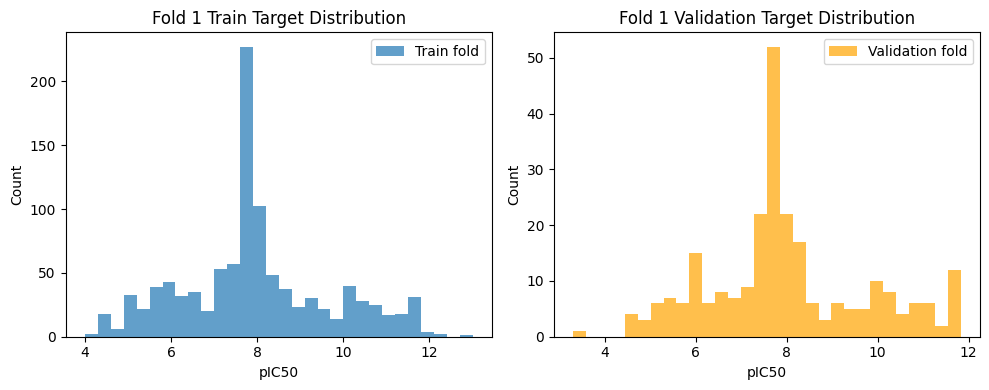

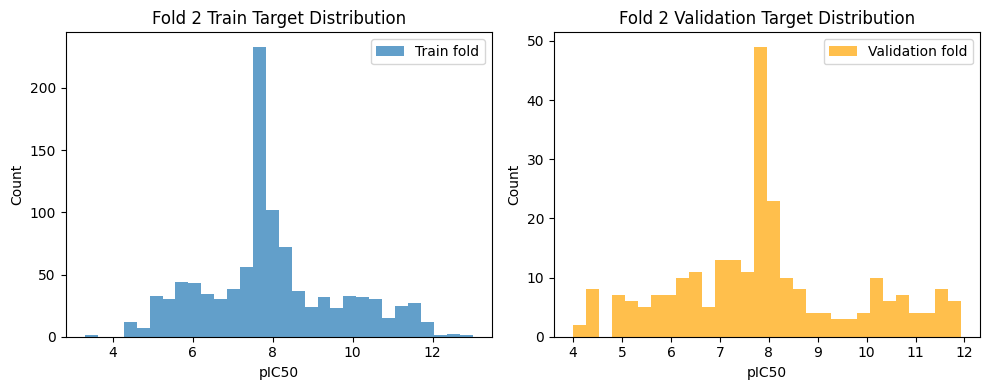

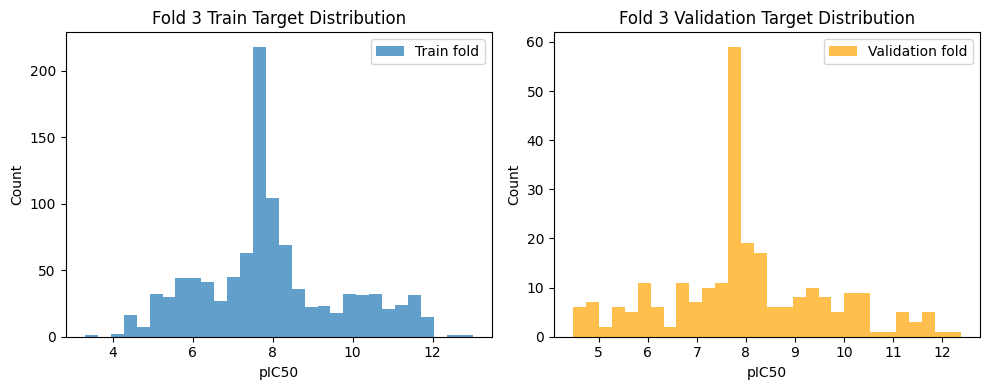

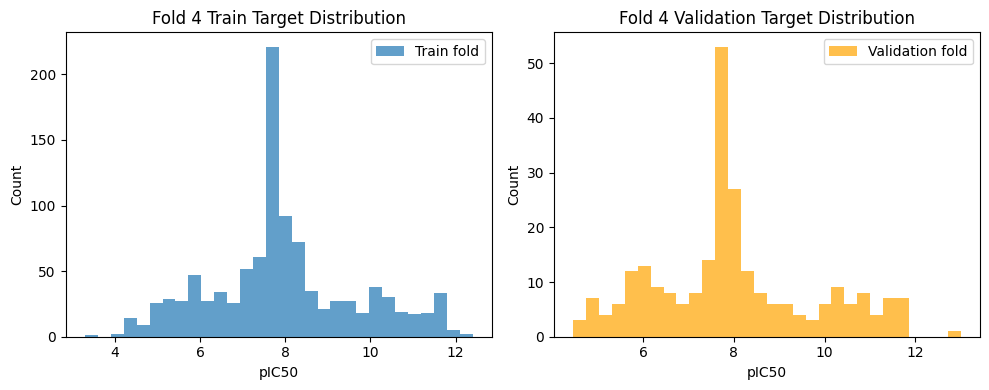

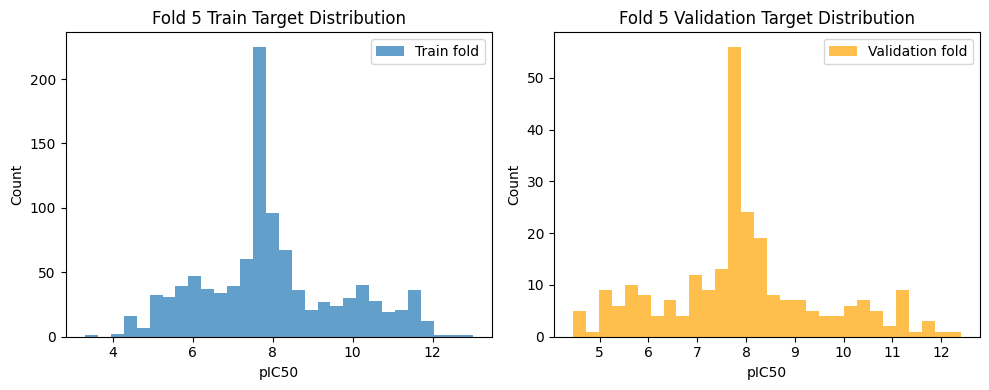

In [104]:
# 각 fold의 Train과 Validation 타겟 분포가 비슷해야 안정적인 평가 가능
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval, y_trainval)):
    y_train_fold = y_trainval.iloc[train_idx]
    y_val_fold = y_trainval.iloc[val_idx]
    
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.hist(y_train_fold, bins=30, alpha=0.7, label='Train fold')
    plt.title(f'Fold {fold+1} Train Target Distribution')
    plt.xlabel('pIC50')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(y_val_fold, bins=30, alpha=0.7, label='Validation fold', color='orange')
    plt.title(f'Fold {fold+1} Validation Target Distribution')
    plt.xlabel('pIC50')
    plt.ylabel('Count')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [105]:
# 평균과 표준편차가 너무 다르면 데이터 분포가 불균형할 가능성
for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval, y_trainval)):
    y_train_fold = y_trainval.iloc[train_idx]
    y_val_fold = y_trainval.iloc[val_idx]
    
    print(f"Fold {fold+1} Train mean: {y_train_fold.mean():.3f}, std: {y_train_fold.std():.3f}")
    print(f"Fold {fold+1} Val mean: {y_val_fold.mean():.3f}, std: {y_val_fold.std():.3f}")
    print('-'*40)


Fold 1 Train mean: 7.944, std: 1.726
Fold 1 Val mean: 7.978, std: 1.736
----------------------------------------
Fold 2 Train mean: 7.966, std: 1.700
Fold 2 Val mean: 7.890, std: 1.834
----------------------------------------
Fold 3 Train mean: 7.942, std: 1.745
Fold 3 Val mean: 7.984, std: 1.654
----------------------------------------
Fold 4 Train mean: 7.940, std: 1.716
Fold 4 Val mean: 7.995, std: 1.773
----------------------------------------
Fold 5 Train mean: 7.962, std: 1.748
Fold 5 Val mean: 7.907, std: 1.641
----------------------------------------


In [106]:
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.007907831868059566, 'num_leaves': 35, 'max_depth': 8, 'feature_fraction': 0.9573948308730402, 'bagging_fraction': 0.8170059879839278, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.46414657633732936, 'lambda_l2': 0.5504587447118142, 'min_split_gain': 0.13169819051671167}


In [107]:
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'n_jobs': -1,
    'seed': CFG['SEED'],
    'boosting_type': 'gbdt',
    'n_estimators': 2000
})

In [108]:
avg_score, oof_preds, lgb_cv_scores = lgb_kfold_cv(best_params, X_trainval, y_trainval, n_splits=CFG['N_SPLITS'], seed=CFG['SEED'])
print("Fold별 점수:", lgb_cv_scores)
print("평균 점수:", np.mean(lgb_cv_scores))

Fold 1 score: 0.565560
Fold 2 score: 0.531776
Fold 3 score: 0.531462
Fold 4 score: 0.507383
Fold 5 score: 0.494475
Average CV score: 0.526131
Fold별 점수: [np.float64(0.5655597974782715), np.float64(0.5317757823140434), np.float64(0.5314620251326125), np.float64(0.5073832602548531), np.float64(0.49447518202143126)]
평균 점수: 0.5261312094402424


In [109]:
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_trainval, y_trainval)

,boosting_type,'gbdt'
,num_leaves,35
,max_depth,8
,learning_rate,0.007907831868059566
,n_estimators,2000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.13169819051671167
,min_child_weight,0.001
,min_child_samples,10


In [110]:
# 앙상블을 위한 가중치 파일 저장
# lgb_cv_scores
# [np.float64(0.5849056490757873),
#  np.float64(0.5563937457354385),
#  np.float64(0.5597421176622719),
#  np.float64(0.5178987367456416),
#  np.float64(0.5003672872809791)]

# 평균 점수 계산
lgb_mean_score = np.mean(lgb_cv_scores)

# JSON 형식으로 저장 (가중치 계산용)
with open('lgb_cv_score.json', 'w') as f:
    json.dump({'mean_score': float(lgb_mean_score)}, f)

print(f"LGBM CV mean score saved: {lgb_mean_score}")

LGBM CV mean score saved: 0.5261312094402424


### Test

In [111]:
test = pd.read_csv("C:/Users/user/Desktop/dacon_drug_development/dataset/test.csv")
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)
test = test[test['Fingerprint'].notnull()]

test_features_df = pd.DataFrame([descriptors(s) for s in test['Smiles']])
test_final_dataset = pd.concat([test, test_features_df], axis=1)
fp_df = pd.DataFrame(test_final_dataset['Fingerprint'].tolist(), index=test_final_dataset.index)
fp_df.columns = [f'fp_{i}' for i in range(fp_df.shape[1])]
test_final_dataset = pd.concat(
    [test_final_dataset.drop(columns=['Fingerprint']), fp_df],
    axis=1
)

X_test = test_final_dataset.drop(['ID', 'Smiles'], axis=1)

[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerator
[12:59:07] DEPRECATION WARNING: please use MorganGenerat

In [112]:
test['pIC50_pred'] = final_model.predict(X_test)
test['ASK1_IC50_nM'] = pIC50_to_IC50(test['pIC50_pred'])

In [113]:
# 앙상블을 위한 예측값 저장
np.save('lgb_test_preds.npy', test['ASK1_IC50_nM'].values)

### Submission

In [114]:
submission = pd.read_csv('C:/Users/user/Desktop/dacon_drug_development/sample_submission.csv') 
submission['ASK1_IC50_nM'] = test['ASK1_IC50_nM']

In [115]:
submission

,ID,ASK1_IC50_nM
0,TEST_000,5.432763
1,TEST_001,7.508395
2,TEST_002,11.487429
3,TEST_003,4.934953
4,TEST_004,8.636549
...,...,...
122,TEST_122,3.961210
123,TEST_123,1.616419
124,TEST_124,3.739520
125,TEST_125,3.032538


In [116]:
submission.to_csv("C:/Users/user/Desktop/dacon_drug_development/LightGBM_4_submission.csv", index=False)